In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as sps
import seaborn as sns
sns.set(style='ticks', font_scale=1.3)

import scipy.optimize

rcParams['figure.figsize'] = 10, 5

from typing import Optional, Union, List, Tuple

In [2]:
import logging

logger = logging.getLogger(__name__)
loglevel = "DEBUG"
logger.setLevel(loglevel)
handler = logging.StreamHandler()
handler.setLevel(loglevel)
format = '%(levelname)s: %(message)s'
handler.setFormatter(logging.Formatter(format))
logger.addHandler(handler)

## Task 2: Gradient descent

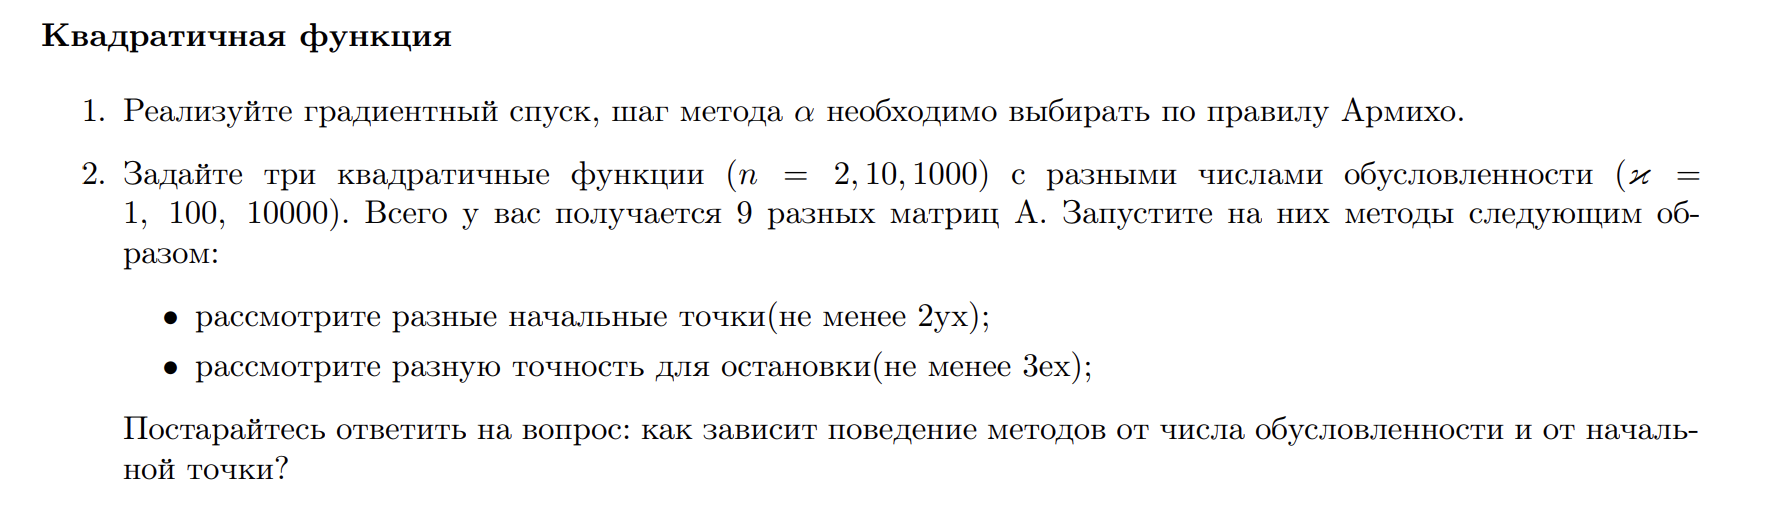

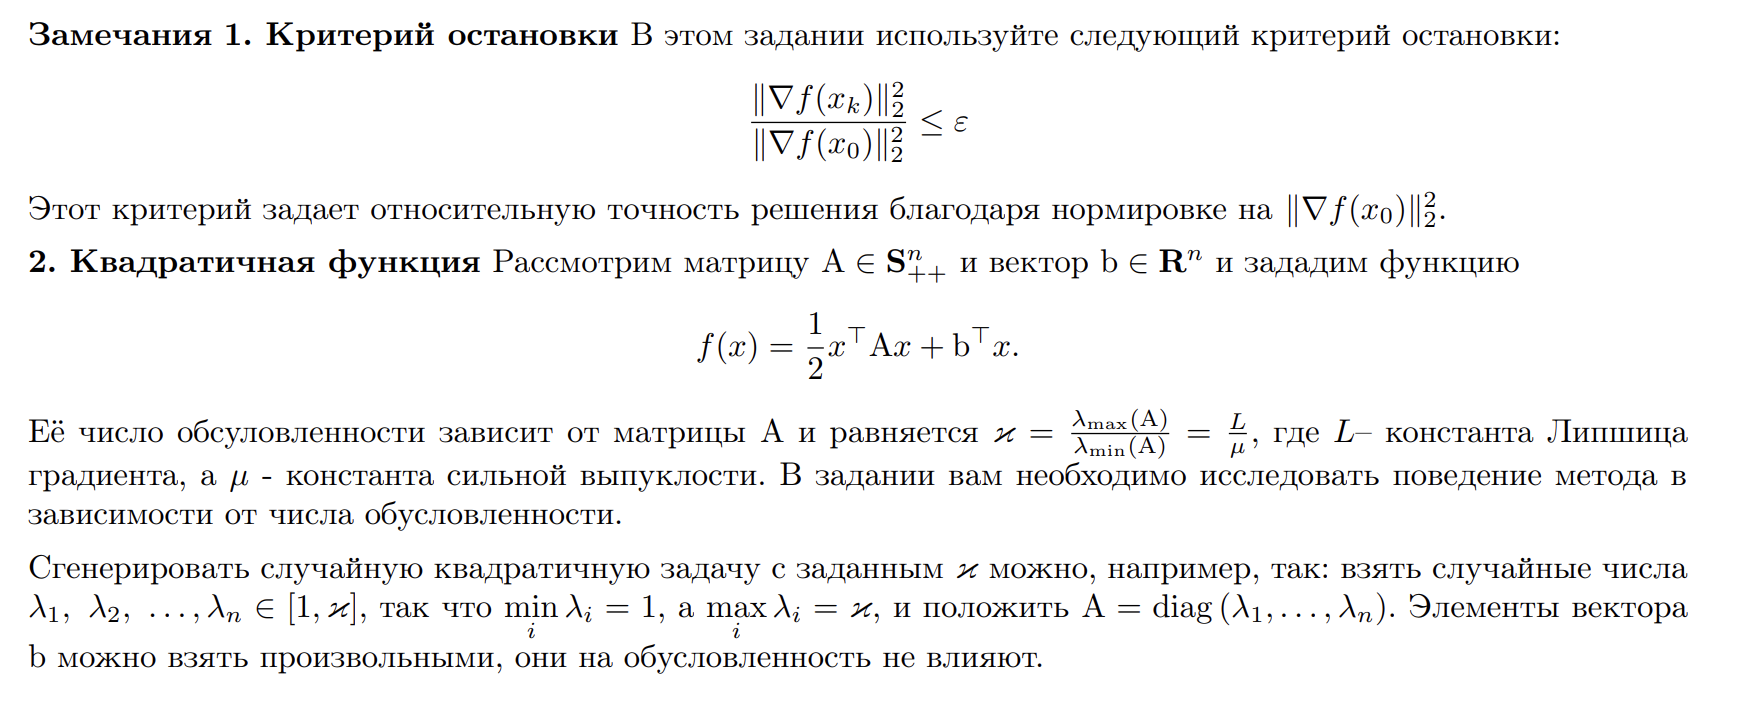

### Functions

In [3]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

In [4]:
def quadratic_func_params(n: int, cond_num: int) -> Tuple[np.ndarray, np.ndarray]:
    """ 
    Generate parameters for quadratic function f(x) = (1/2) * (x.T @ A @ x) + (b.T @ x)
    
    :param n: dimension of x
    :param cond_num: condition number of matrix A
    :return: A, b
    """
    lambdas = sps.uniform(loc=1, scale=cond_num).rvs(size=n)
    lambdas[np.argmin(lambdas)] = 1
    lambdas[np.argmax(lambdas)] = cond_num

    A = np.diagflat(lambdas)
    b = np.random.rand(n) * 5
    
    return A, b

In [5]:
def draw_convergence_plot(f_vals: np.ndarray, N_iterations: int, label: Optional[str] = None):

    plt.plot(np.arange(N_iterations), f_vals[:N_iterations], lw=3, label=label)

    plt.ylabel("Function value")
    plt.xlabel("Number of iteration")
    if label is not None: plt.legend()
    plt.grid()

In [6]:
def draw_alpha_plot(alphas: np.ndarray, N_iterations: int):
    
    plt.plot(np.arange(N_iterations), alphas[:N_iterations], lw=3)

    plt.ylabel("Step alpha")
    plt.xlabel("Number of iteration")
    plt.grid()

### Grad descent

In [7]:
def gradient_descent(n: int, N: int, alpha: float, eps: float, 
                     A: np.ndarray, b: np.ndarray,
                     x0: Optional[np.ndarray] = None, 
                     verbose: bool = False):
    """
    Gradient method
    
    :param n: size of x
    :param N: maximim number of iterations
    :param alpha: initial gradient step
    :param eps: tolerance
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param x0: initial guess of x
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    if x0 is None:
        x0 = np.random.rand(n)
    
    x = np.zeros((N, n))
    x[0] = x0
    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], A, b)
    alphas = np.zeros(N)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    
    end_iteration = N
    
    for k in range(N-1): 
        
        h_k = grad_f(x[k], A, b)
        
        # Armijo rule
        while f(x[k] - alpha * h_k, A, b) > f(x[k], A, b) + 0.2 * alpha * (h_k @ h_k):
            alpha_new = alpha * 0.5
            logger.debug(f"iteration: {k}; Armijo condition is not true, change alpha from {alpha:.6f} to {alpha_new:.6f}")
            alpha = alpha_new
        
        alphas[k] = alpha
        
        # GD step
        x[k+1] = x[k] - alpha * h_k
                
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        if stop_criteria:
            end_iteration = k+1
            logger.info(f'GD converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x[k+1]}')
            break


    if not stop_criteria:
        logger.info(f'(!) GD didnt converge, may be need to increase number of iterations N')
        logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
        
        
    return f_vals, x, end_iteration, alphas

Пример: градиентный спуск

Задаем матрицу А и столбец b в функции f(x)

In [8]:
n = 2
cond_num = 100

A, b = quadratic_func_params(n, cond_num)
A, b

(array([[  1.,   0.],
        [  0., 100.]]),
 array([2.61779719, 4.09239779]))

Запускаем град спуск

In [9]:
N = int(1e5)
alpha = 2
eps = 1e-10
x0 = np.random.rand(n)*5 + 10

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 2.000000 to 1.000000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 1.000000 to 0.500000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.500000 to 0.250000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.250000 to 0.125000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.125000 to 0.062500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.062500 to 0.031250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.031250 to 0.015625
INFO: GD converge at 450 iteration, min f(x) = -3.5100695467563856
DEBUG: x_min = [-2.60364688 -0.04092398]


Сравним результат со scipy

In [10]:
scipy.optimize.minimize(f, x0, args=(A, b))

      fun: -3.5101696623688117
 hess_inv: array([[ 1.00013153e+00, -2.36148198e-06],
       [-2.36148198e-06,  1.00000428e-02]])
      jac: array([ 2.98023224e-07, -5.06639481e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-2.61779693, -0.04092399])

Посмотрим на график сходимости метода

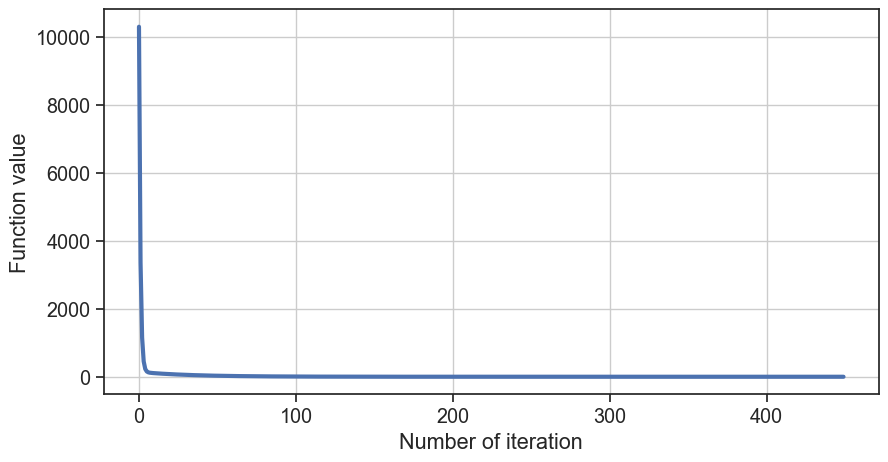

In [11]:
draw_convergence_plot(f_vals, N_iterations)

### Генерация 9 матриц с разными числами обусловленности

In [12]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -0.48020481507556334


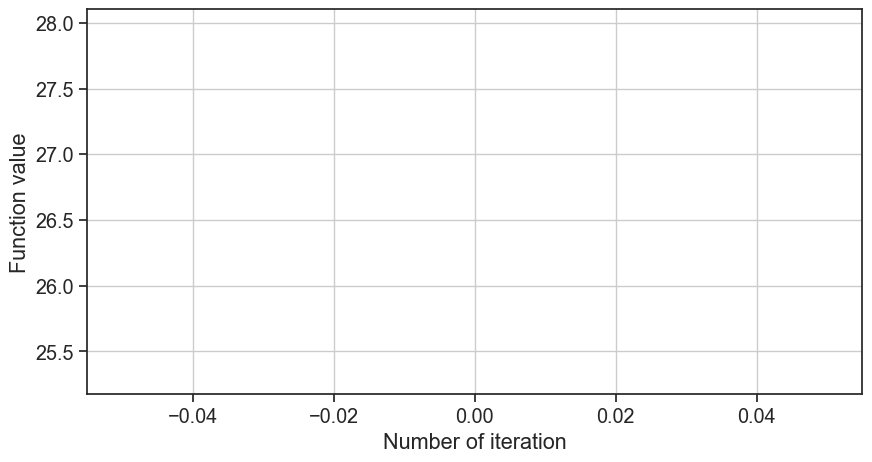

INFO: n = 2, condition number = 100
INFO: GD converge at 414 iteration, min f(x) = -0.5668622608579098


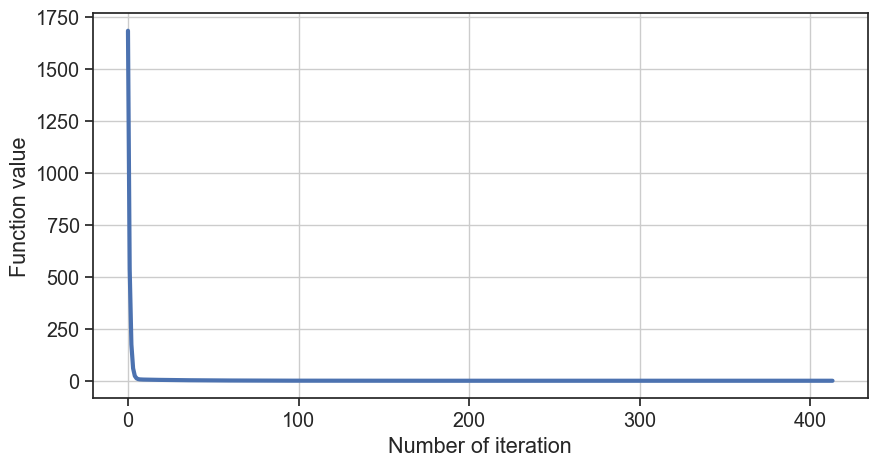

INFO: n = 2, condition number = 1000
INFO: GD converge at 2378 iteration, min f(x) = -4.90004897015968


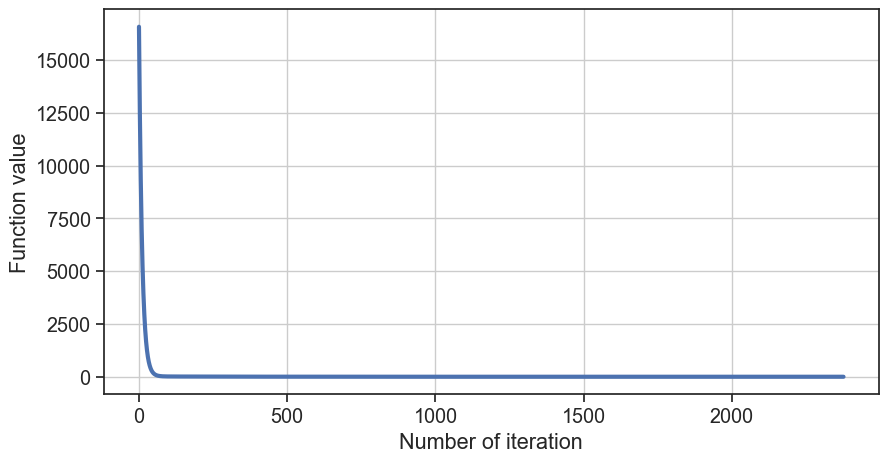

INFO: n = 10, condition number = 1
INFO: GD converge at 75 iteration, min f(x) = -28.36336322142462


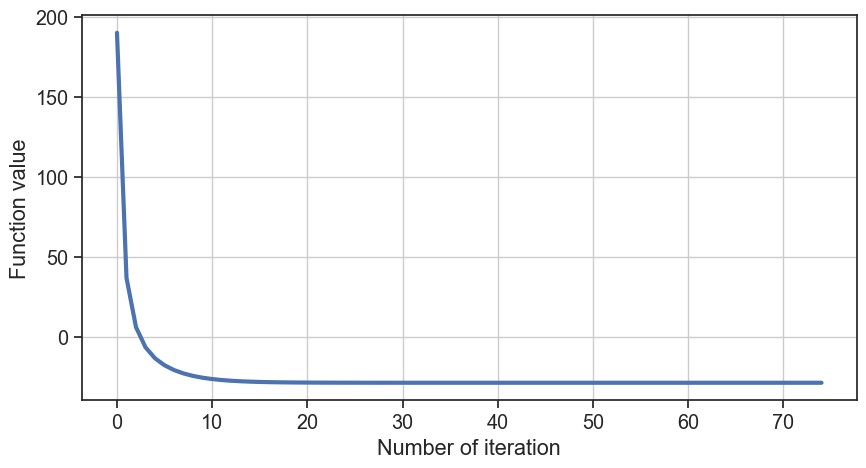

INFO: n = 10, condition number = 100
INFO: GD converge at 405 iteration, min f(x) = -7.663352392154365


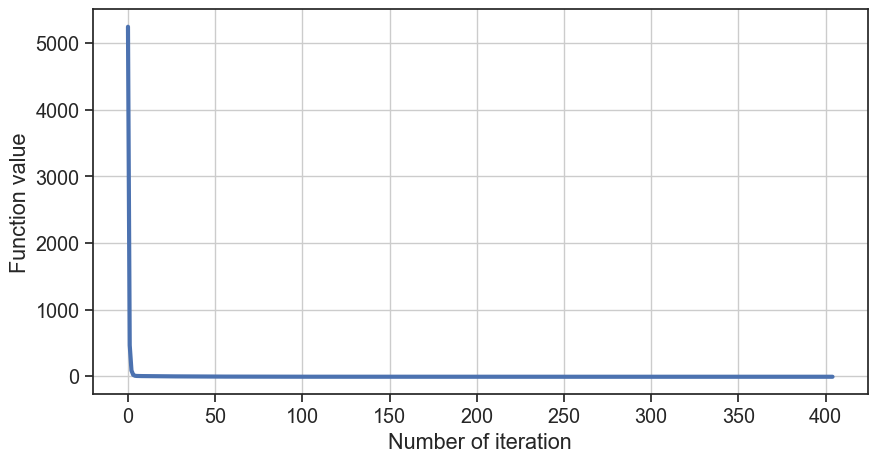

INFO: n = 10, condition number = 1000
INFO: GD converge at 2264 iteration, min f(x) = -11.29395491755684


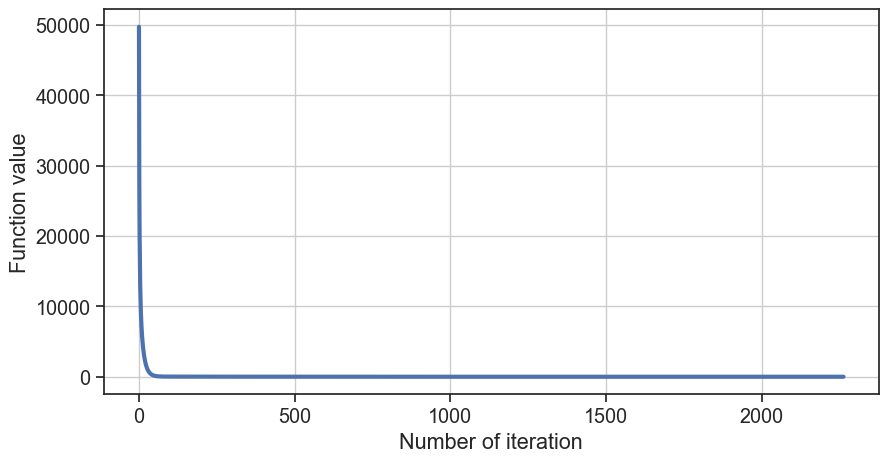

INFO: n = 1000, condition number = 1
INFO: GD converge at 4004 iteration, min f(x) = -2914.1684378973478


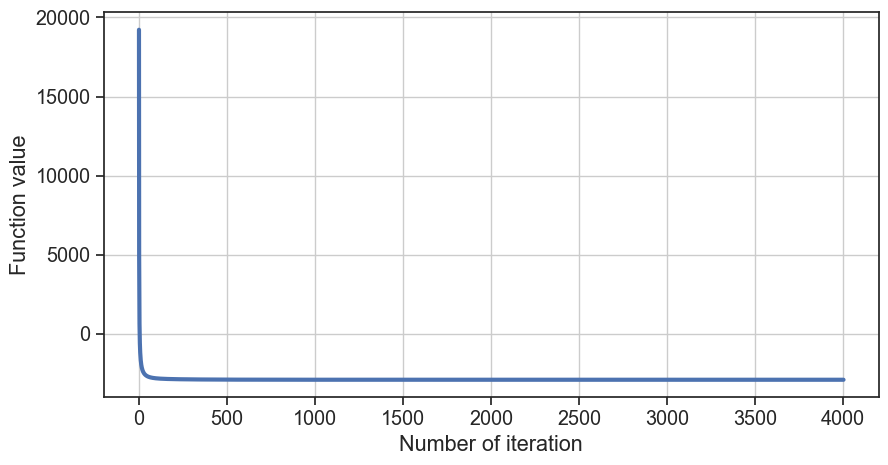

INFO: n = 1000, condition number = 100
INFO: GD converge at 305 iteration, min f(x) = -202.01165520814175


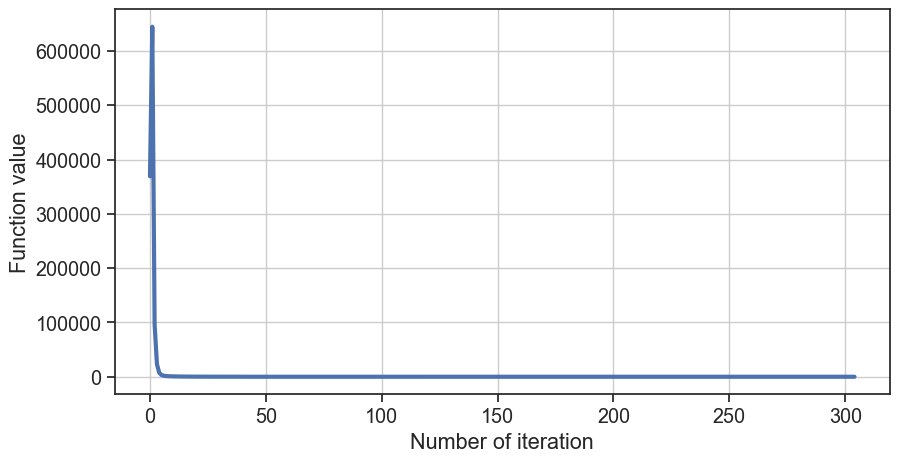

INFO: n = 1000, condition number = 1000
INFO: GD converge at 1109 iteration, min f(x) = -29.91169817818102


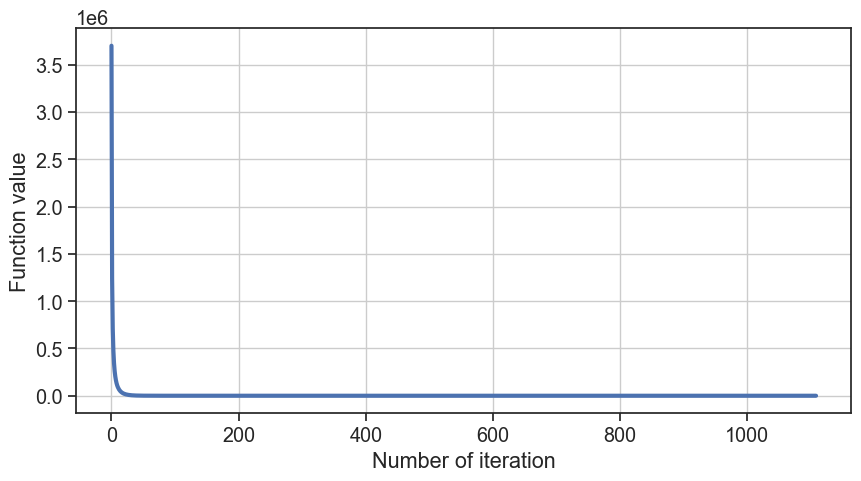

In [13]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
    
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -0.48020481507556334


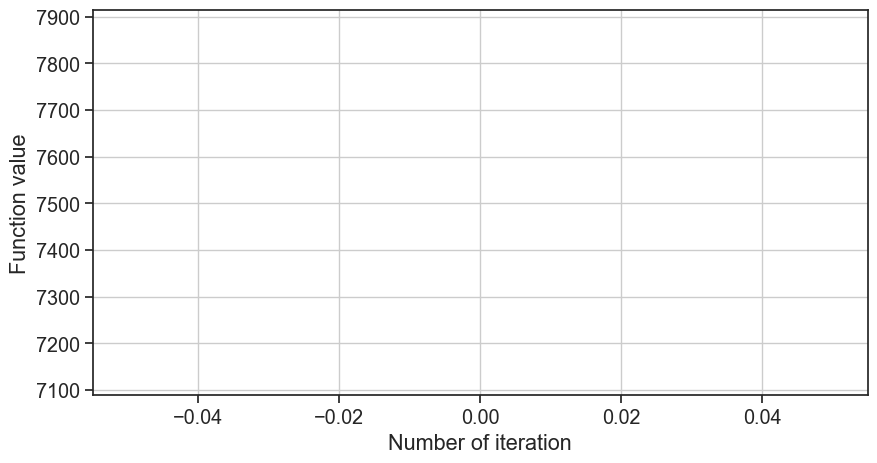

INFO: n = 2, condition number = 100
INFO: GD converge at 407 iteration, min f(x) = -0.5615503075483689


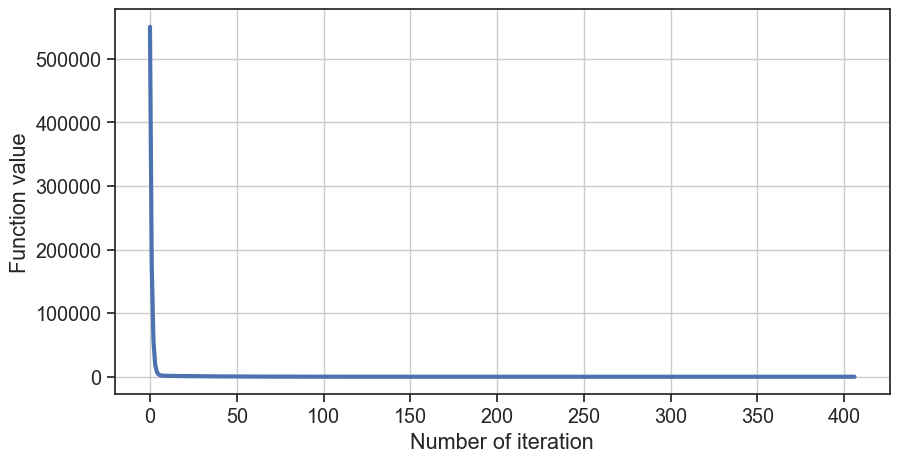

INFO: n = 2, condition number = 1000
INFO: GD converge at 2111 iteration, min f(x) = -4.354436005348671


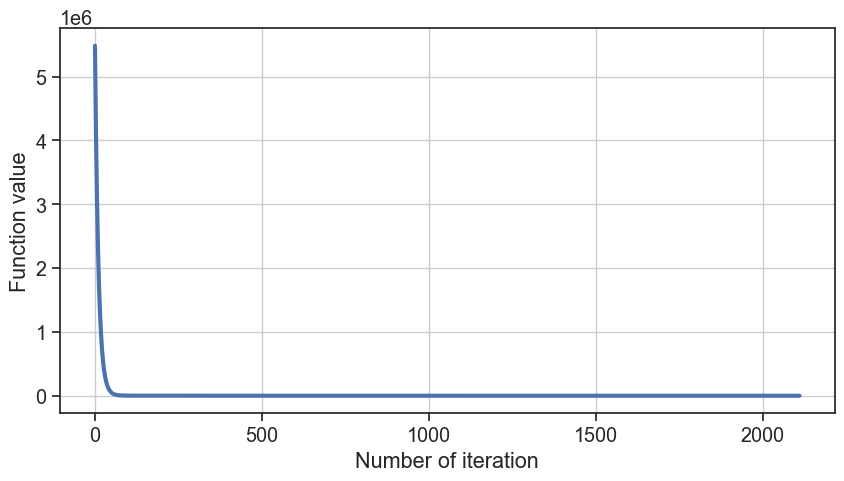

INFO: n = 10, condition number = 1
INFO: GD converge at 75 iteration, min f(x) = -28.36336108794606


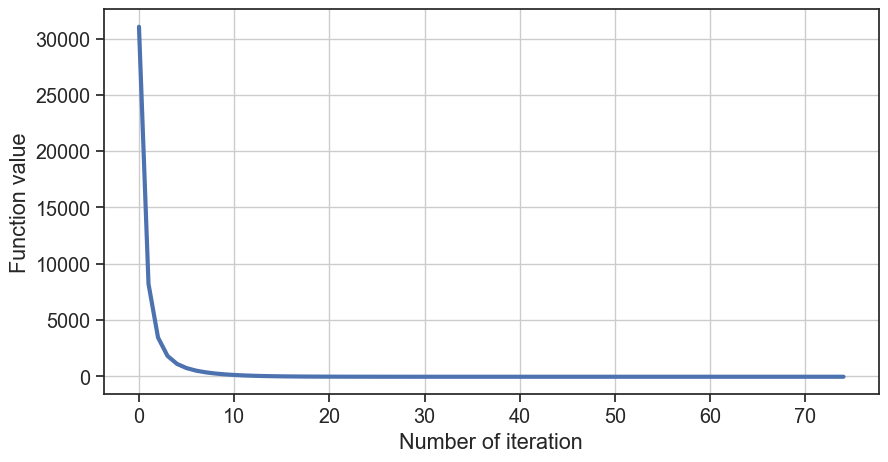

INFO: n = 10, condition number = 100
INFO: GD converge at 338 iteration, min f(x) = -7.652312938473117


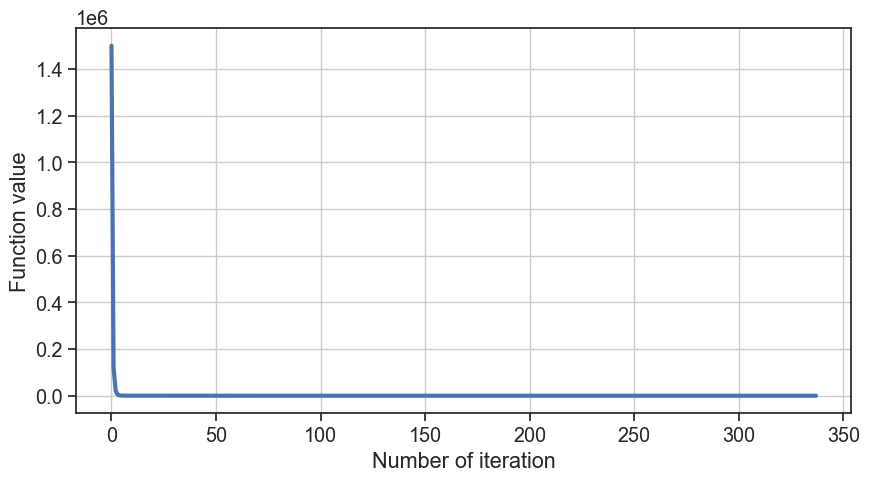

INFO: n = 10, condition number = 1000
INFO: GD converge at 1962 iteration, min f(x) = -10.268858518503619


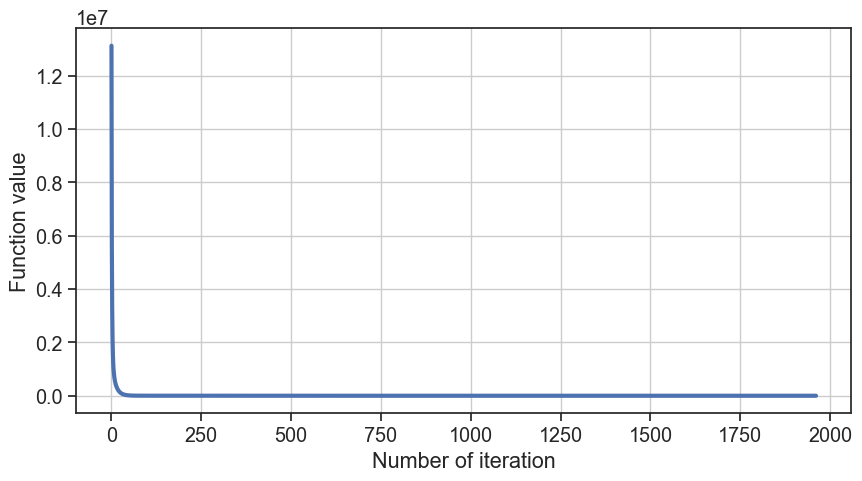

INFO: n = 1000, condition number = 1
INFO: GD converge at 4062 iteration, min f(x) = -2914.168187586959


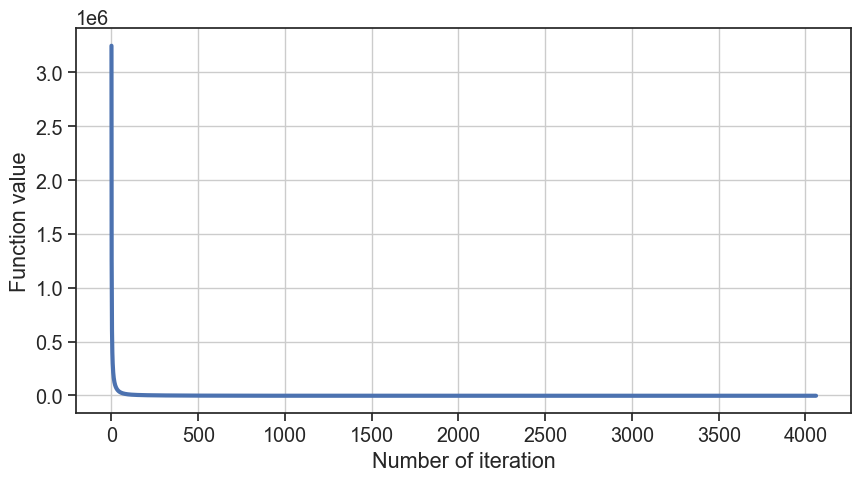

INFO: n = 1000, condition number = 100
INFO: GD converge at 271 iteration, min f(x) = -201.31546113919921


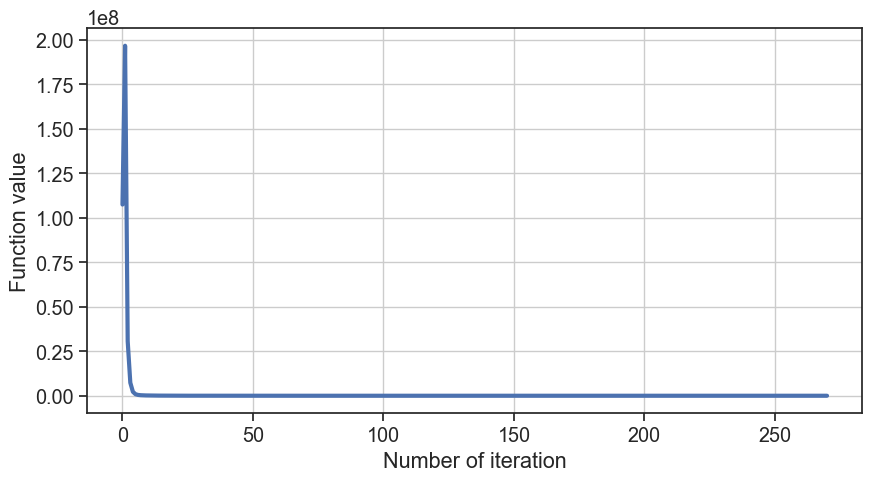

INFO: n = 1000, condition number = 1000
INFO: GD converge at 828 iteration, min f(x) = 42.545796040092796


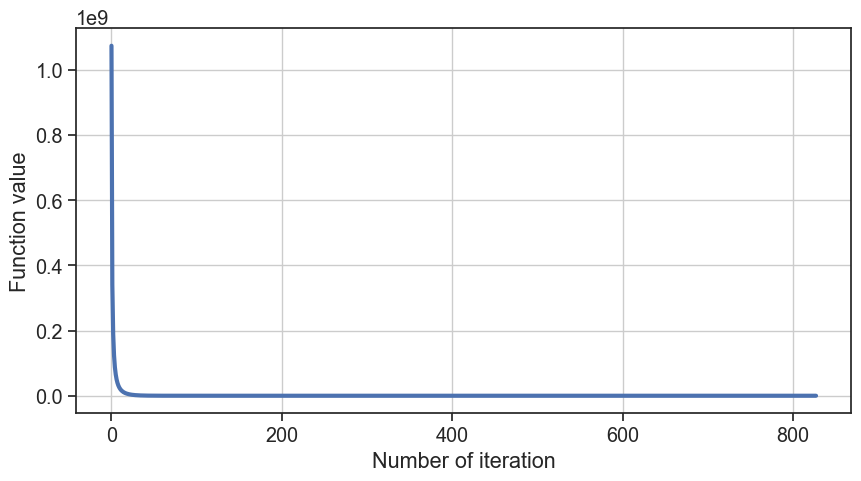

In [14]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=23)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -0.48020481507556334


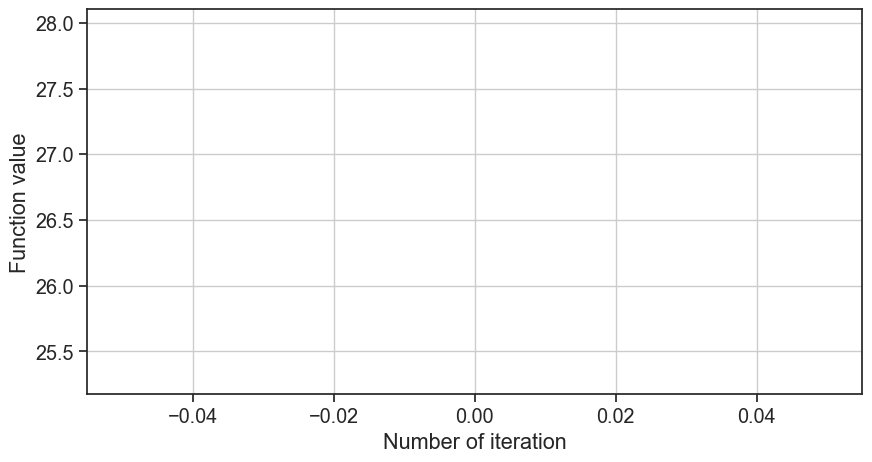

INFO: n = 2, condition number = 100
INFO: GD converge at 48 iteration, min f(x) = 1.0839358288694565


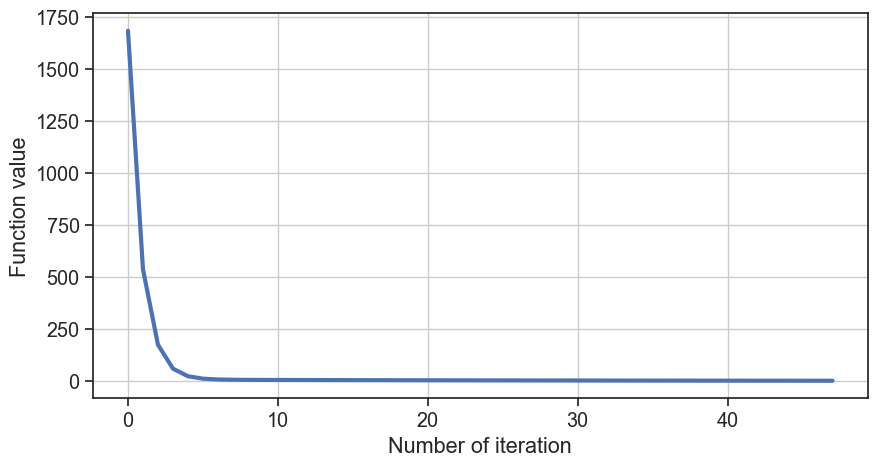

INFO: n = 2, condition number = 1000
INFO: GD converge at 121 iteration, min f(x) = 6.47534241667531


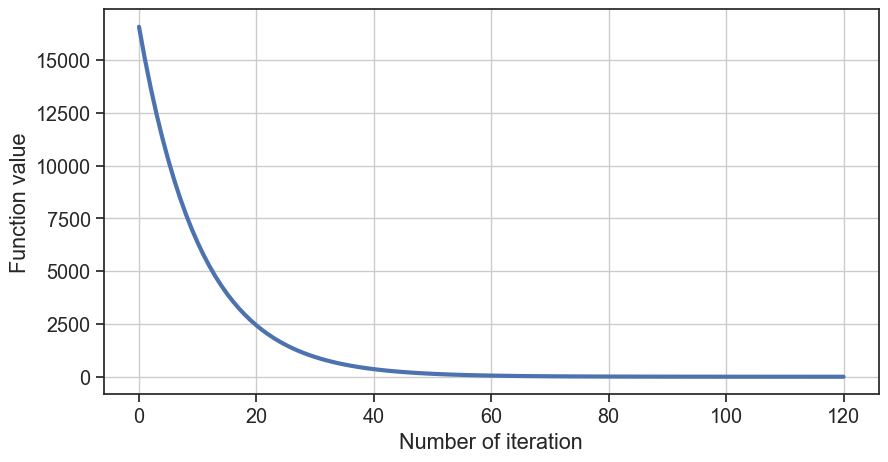

INFO: n = 10, condition number = 1
INFO: GD converge at 34 iteration, min f(x) = -28.36166307429724


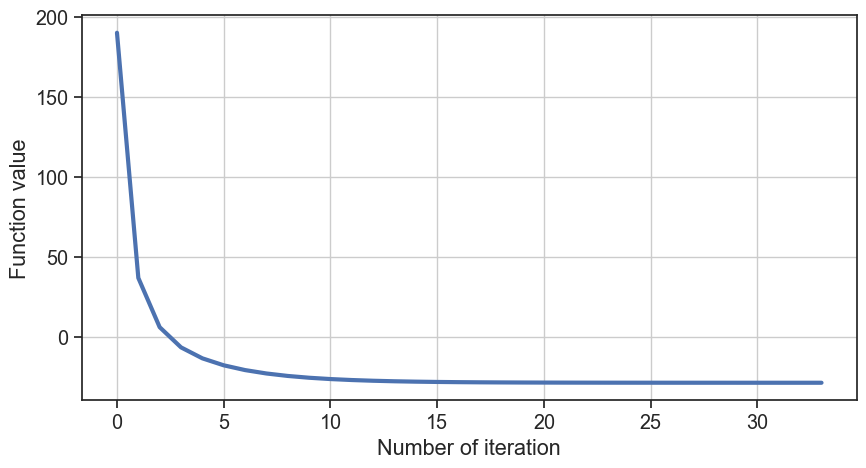

INFO: n = 10, condition number = 100
INFO: GD converge at 39 iteration, min f(x) = -3.8755510122853565


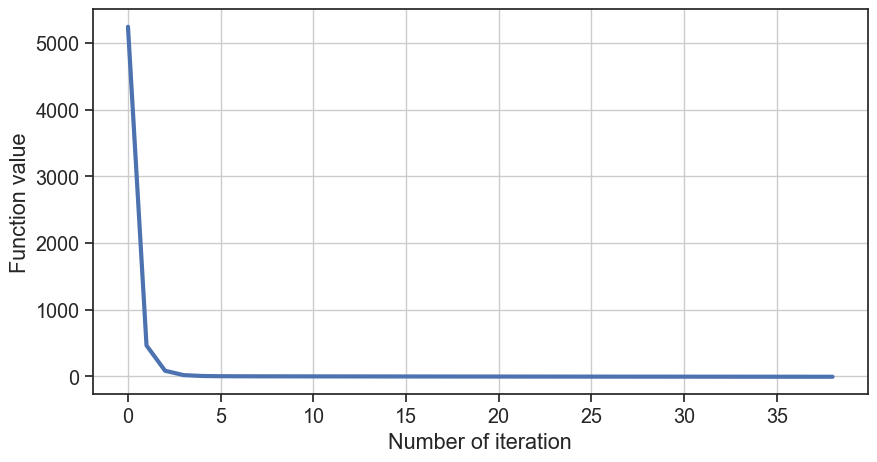

INFO: n = 10, condition number = 1000
INFO: GD converge at 110 iteration, min f(x) = 7.922478659353316


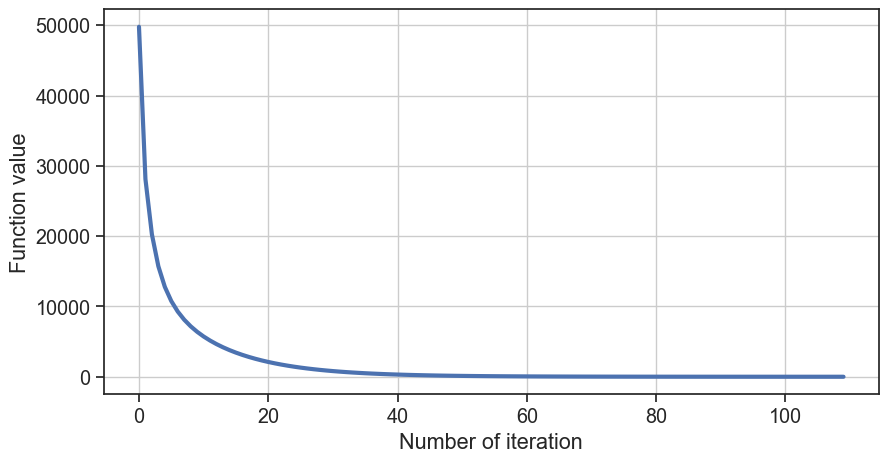

INFO: n = 1000, condition number = 1
INFO: GD converge at 1344 iteration, min f(x) = -2914.0006642144326


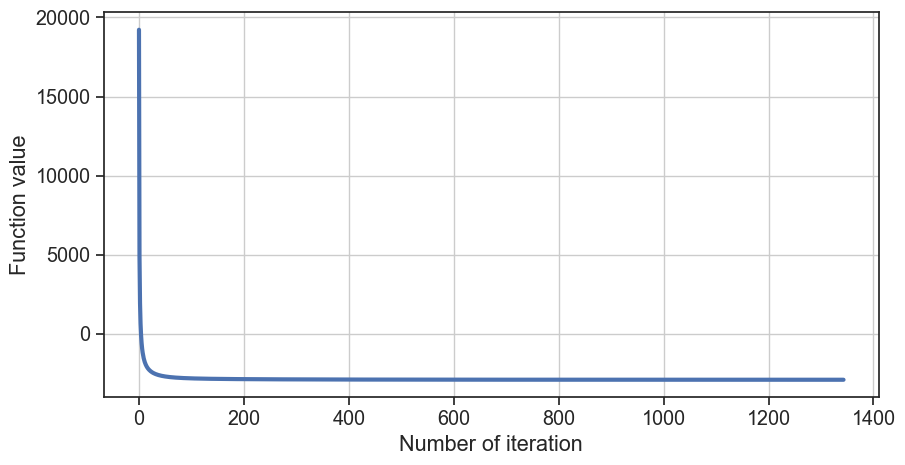

INFO: n = 1000, condition number = 100
INFO: GD converge at 27 iteration, min f(x) = -100.79595024986935


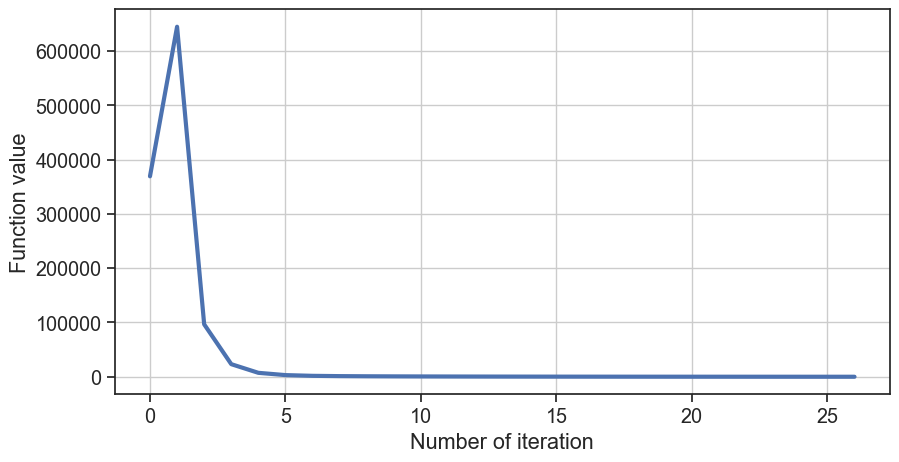

INFO: n = 1000, condition number = 1000
INFO: GD converge at 80 iteration, min f(x) = 75.26782745536225


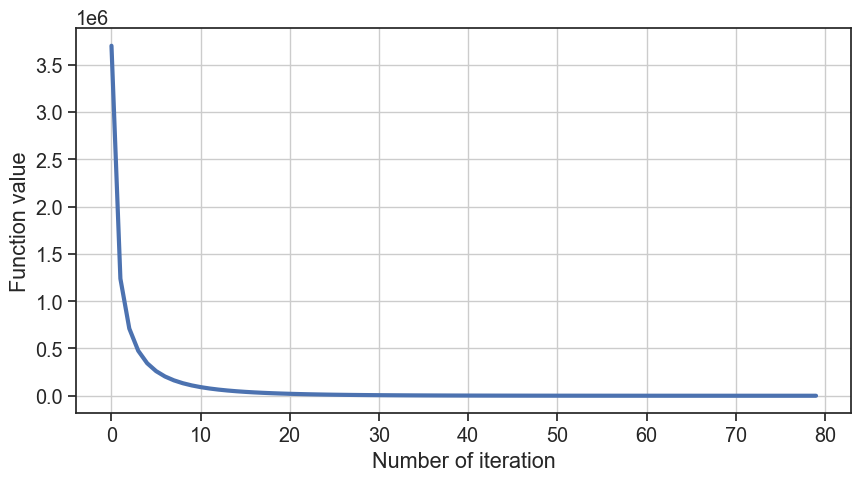

In [15]:
N = int(1e4)
eps = 1e-5

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -0.48020481507556334


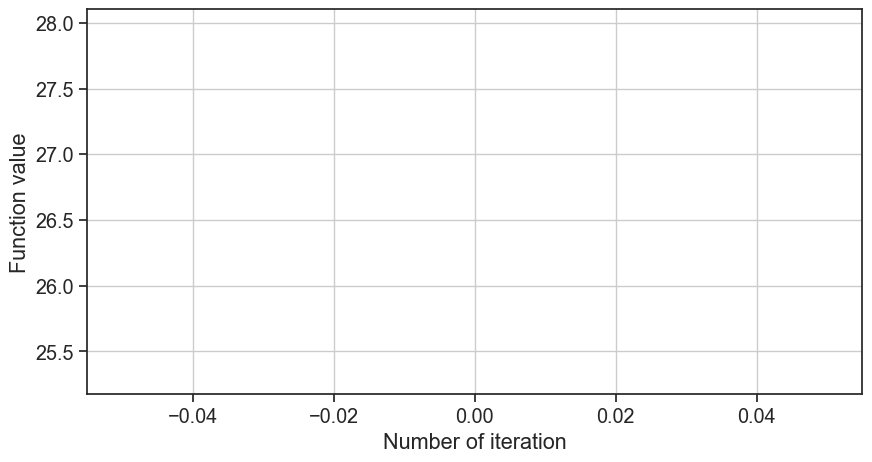

INFO: n = 2, condition number = 100
INFO: GD converge at 267 iteration, min f(x) = -0.5652111618037707


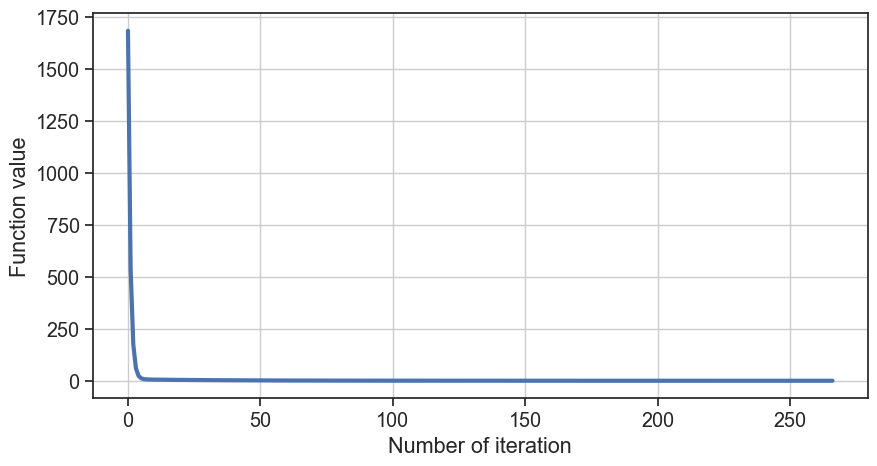

INFO: n = 2, condition number = 1000
INFO: GD converge at 1200 iteration, min f(x) = -4.736492304139636


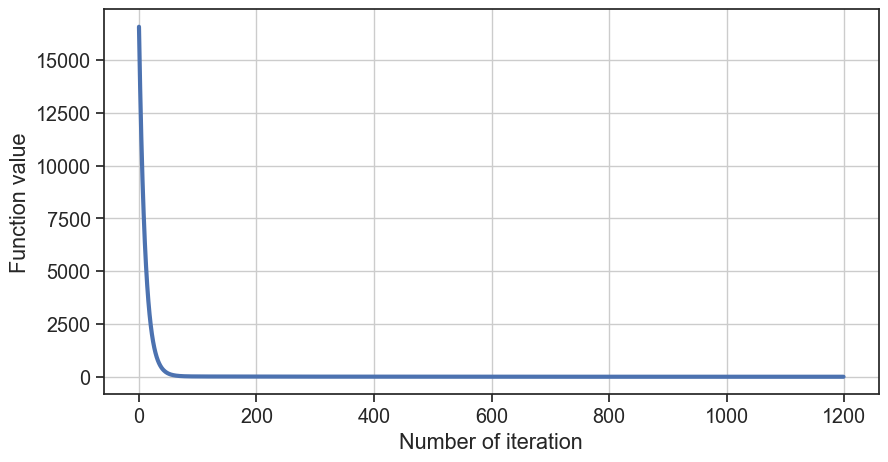

INFO: n = 10, condition number = 1
INFO: GD converge at 58 iteration, min f(x) = -28.363361530825713


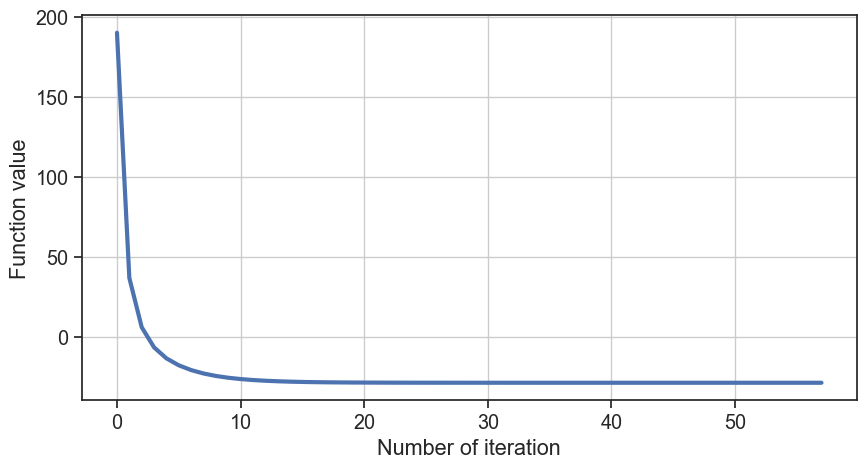

INFO: n = 10, condition number = 100
INFO: GD converge at 258 iteration, min f(x) = -7.65956390020342


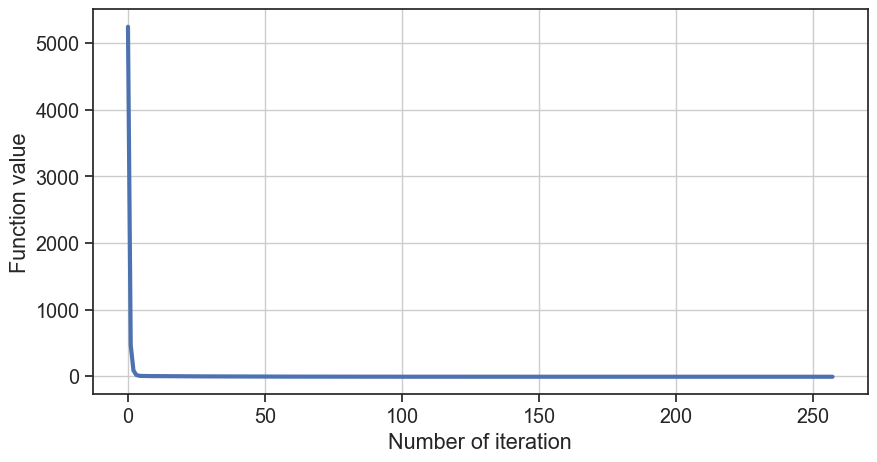

INFO: n = 10, condition number = 1000
INFO: GD converge at 1086 iteration, min f(x) = -10.88313949509641


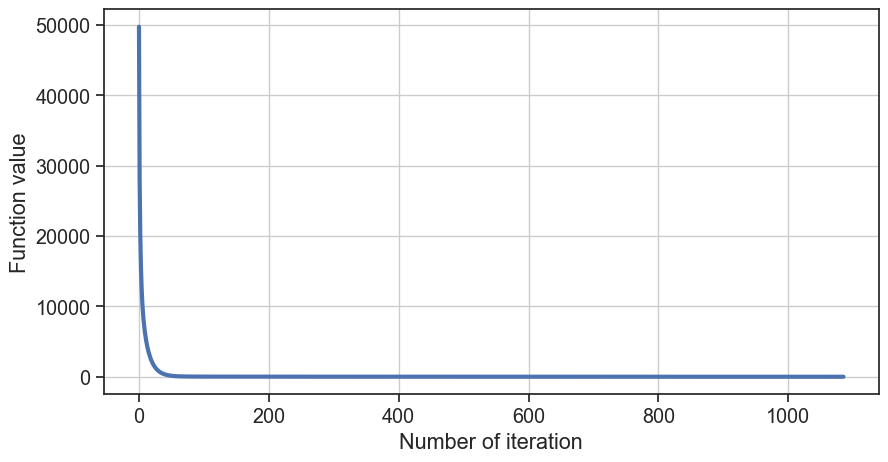

INFO: n = 1000, condition number = 1
INFO: GD converge at 2935 iteration, min f(x) = -2914.168272402365


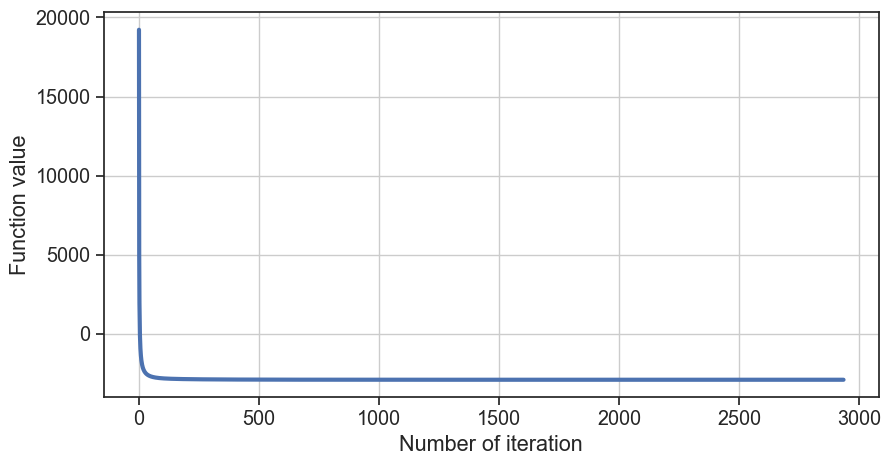

INFO: n = 1000, condition number = 100
INFO: GD converge at 170 iteration, min f(x) = -201.796891569176


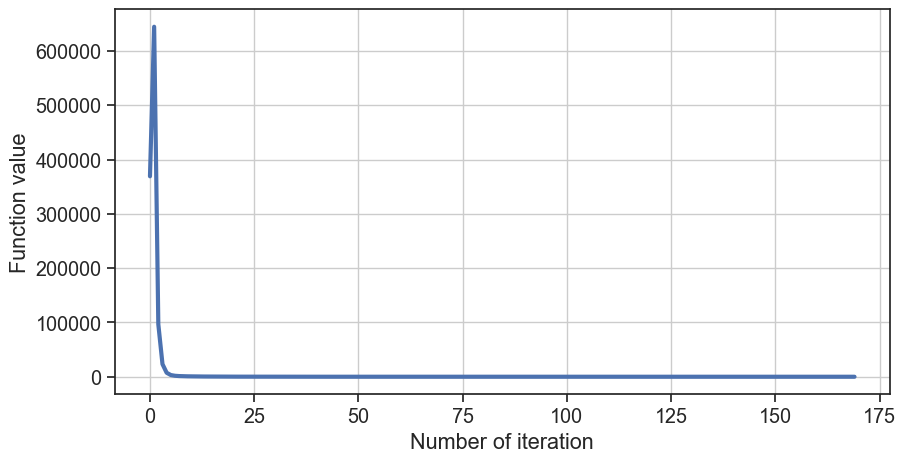

INFO: n = 1000, condition number = 1000
INFO: GD converge at 207 iteration, min f(x) = -18.413794212061667


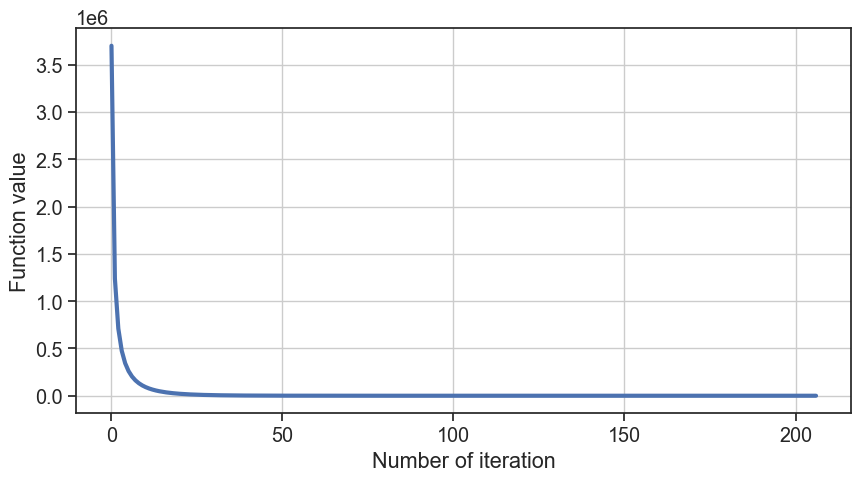

In [16]:
N = int(1e4)
eps = 1e-8

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -0.48020481507556334


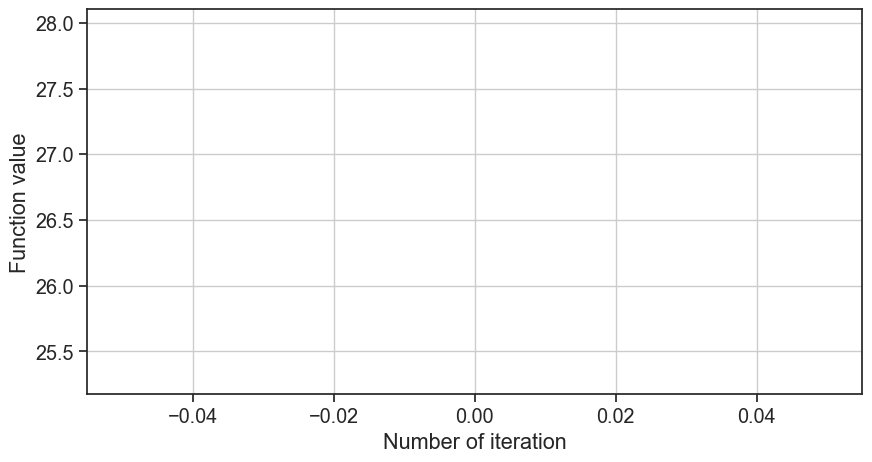

INFO: n = 2, condition number = 100
INFO: GD converge at 560 iteration, min f(x) = -0.5668783615818829


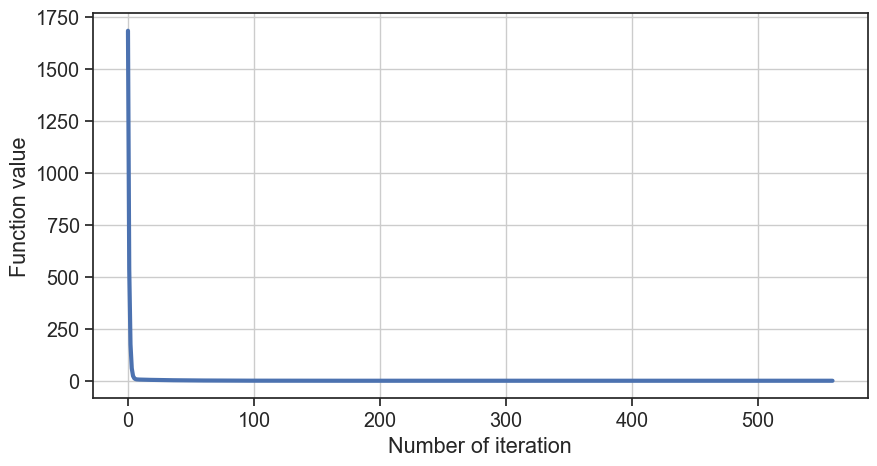

INFO: n = 2, condition number = 1000
INFO: GD converge at 3555 iteration, min f(x) = -4.901683014120995


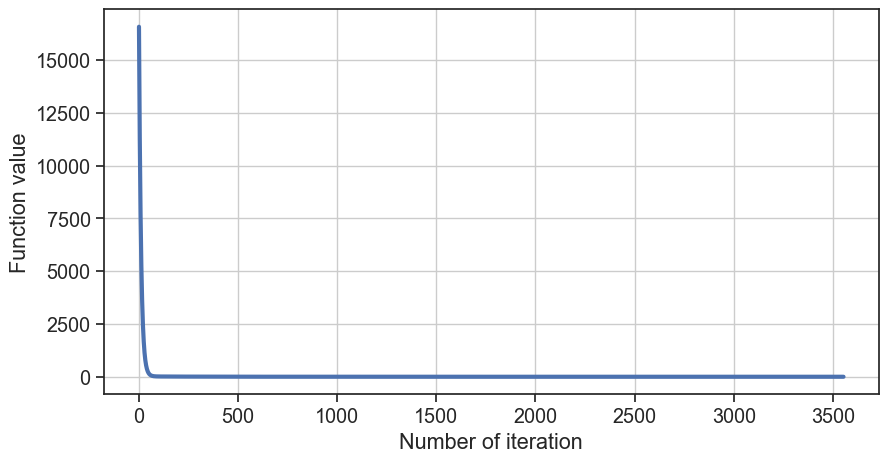

INFO: n = 10, condition number = 1
INFO: GD converge at 92 iteration, min f(x) = -28.36336323684351


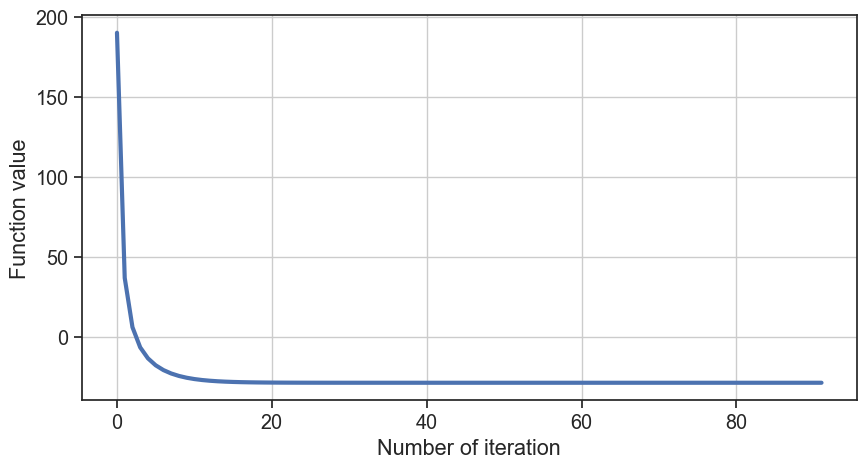

INFO: n = 10, condition number = 100
INFO: GD converge at 551 iteration, min f(x) = -7.663389335706008


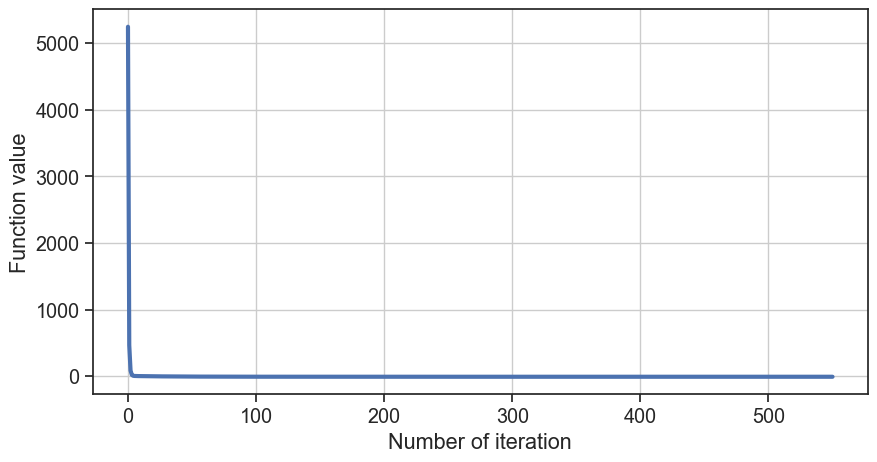

INFO: n = 10, condition number = 1000
INFO: GD converge at 3442 iteration, min f(x) = -11.298059409404878


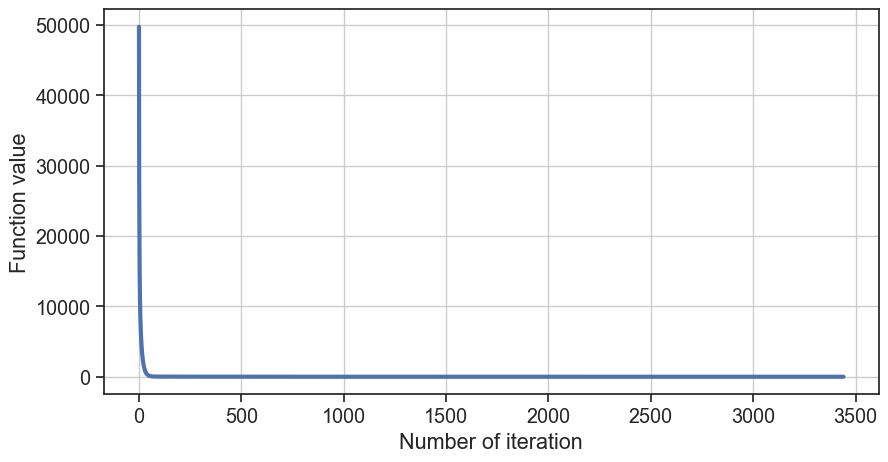

INFO: n = 1000, condition number = 1
INFO: GD converge at 5073 iteration, min f(x) = -2914.168439551697


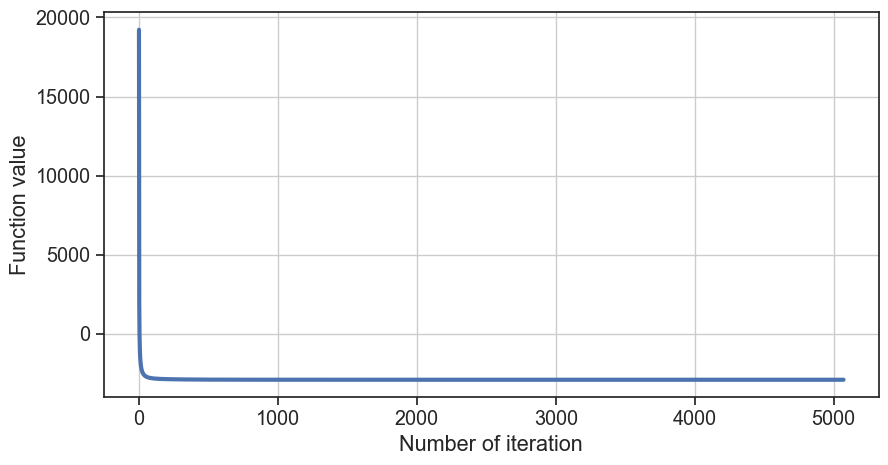

INFO: n = 1000, condition number = 100
INFO: GD converge at 448 iteration, min f(x) = -202.01398103024133


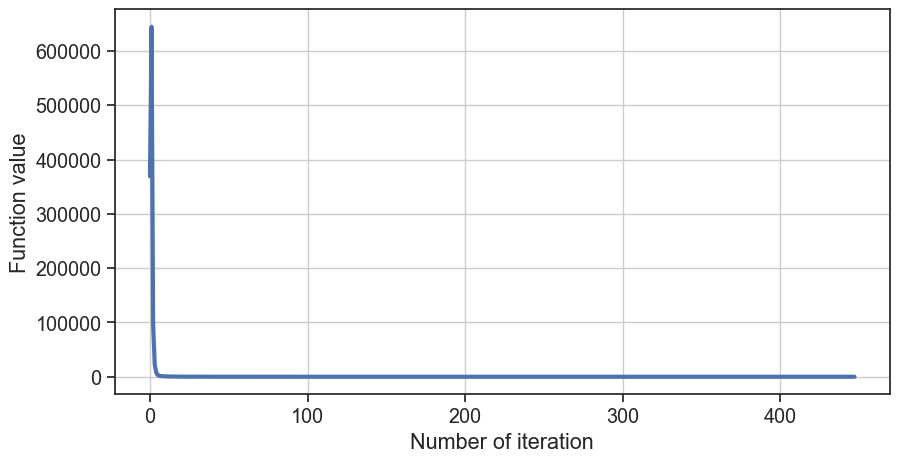

INFO: n = 1000, condition number = 1000
INFO: GD converge at 2287 iteration, min f(x) = -30.164838450522257


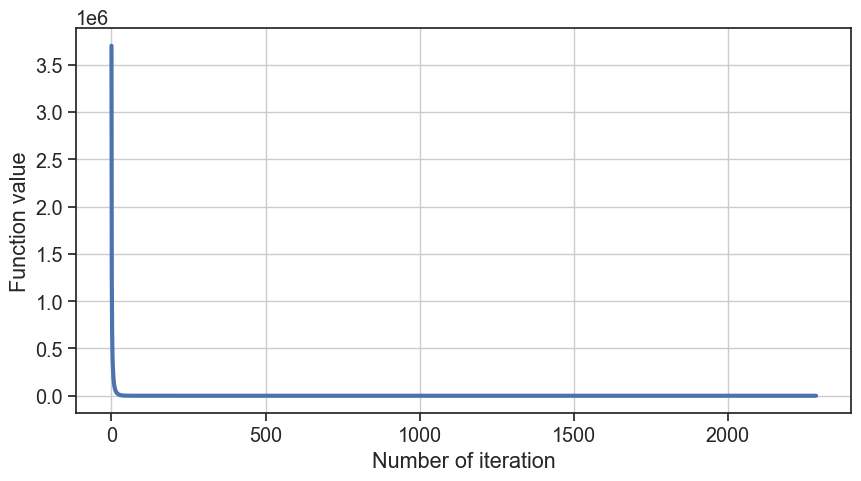

In [17]:
N = int(1e4)
eps = 1e-12

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

**Как зависит поведение методов от числа обусловленности и от начальной точки?**

Число итераций градиентного спуска, необходимых для достижения заданной точки увеличивается с ростом числа обусловленности.

При небольших числах обусловленности градиентный спуск почти не зависит от начальной точки. 

Для числа обусловленности 1000 градиентный спуск, запущенный при разных начальных точках может давать разные результаты. Чтобы этого избежать, нужно повысить требуемую точность (т. е. уменьшить значение `eps`)


Чем меньше значение точности `eps`, тем больше итераций требуется для ее достижения, но ответ получается точнее.

## Task 3: Rosenbrock function

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

$$ x^0 = (1.2, ~ 1.2), ~ x^0 = (-1.2, ~ 1) $$

1. Аналитически найдите точку минимума.
2. Исследуйте зависимость сходимости градиентного спуска от начального приближения, шаг метода выбирать по правилу Армихо. Необходимо рассмотреть как минимум 2 разные начальные точки $x_0$ и и 3 разные точности $\varepsilon$.
3. Постройте график зависимости длины шага от итерации для каждой начальной точки. Какой вывод Вы можете сделать?



---

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

Найдем точку минимума:
$$ \frac{\partial f}{\partial x_1} = - 400 x_1 (x_2 - x_1^2) + 2(x_1 - 1)  = 0 \quad \quad (1)
$$
$$ \frac{\partial f}{\partial x_2} = 200 (x_2 - x_1^2) = 0 \quad \quad (2) $$

$$ (2) \Rightarrow (x_2 - x_1^2) = 0 \rightarrow (1) \rightarrow x_1 - 1 = 0$$

$$x_1 = 1 \rightarrow (1) \Rightarrow x_2 = 1$$

**Минимум функции**:
$$ (x_1^*, x_2^*) = (1, 1); \quad f(x_1^*, x_2^*) = 0 $$


---

In [18]:
def f(x, A, b):
    """Rosenbrock function"""
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def grad_f(x, A, b):
    """Gradient of Rosenbrock function f(x1, x2)"""
    x1, x2 = x
    grad_x = -400 * x1 * (x2 - x1**2) + 2 * (x1 - 1)
    grad_y = 200 * (x2 - x1**2)
    
    return np.array([grad_x, grad_y])


1) Начальная точка $ x^0 = (1.2, ~ 1.2)$

In [20]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.003516 to 0.001758
INFO: GD converge at 2065 iteration, min f(x) = 0.00020048775018694125
DEBUG: x_min = [1.01414824 1.02855278]


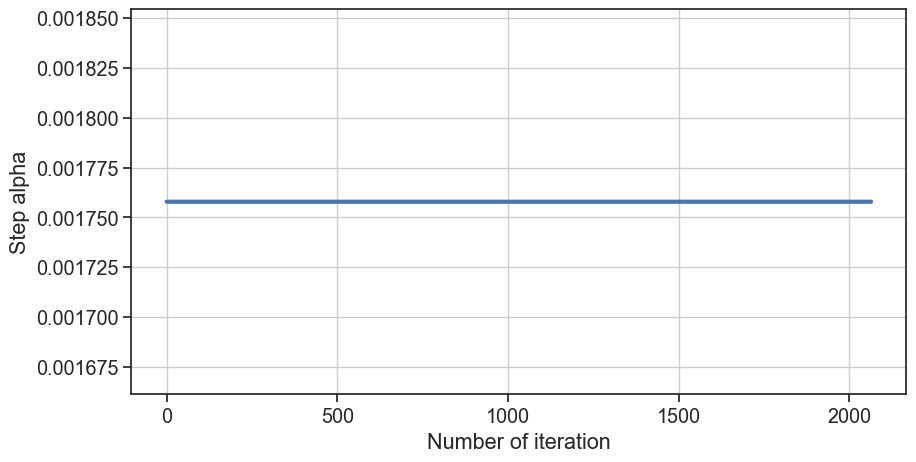

In [21]:
draw_alpha_plot(alphas, N_iterations)

2) Начальная точка $ x^0 = (-1.2, ~ 1)$

In [22]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([-1.2, 1])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.003516 to 0.001758
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.001758 to 0.000879
INFO: GD converge at 9145 iteration, min f(x) = 0.0006513648687563363
DEBUG: x_min = [0.97449919 0.9

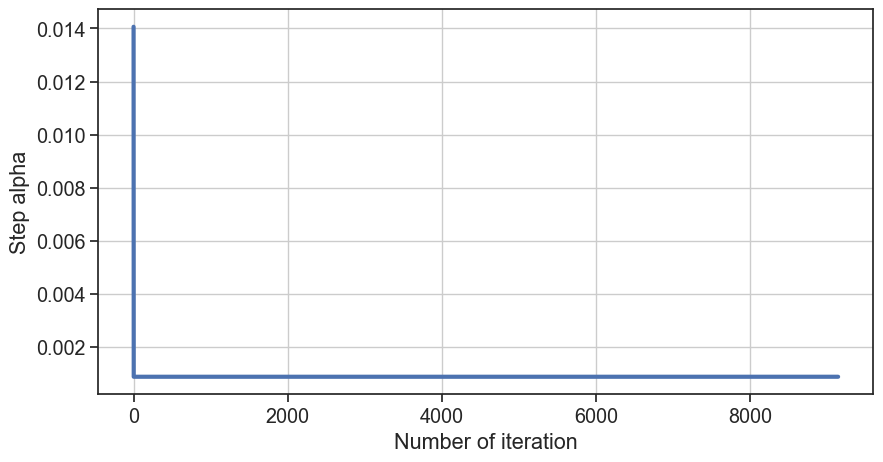

In [23]:
draw_alpha_plot(alphas, N_iterations)

**Вывод:** 

Видим, что в данном случае число итераций необходимых для сходимости может вырасти в 3 раза при неудачном начальном приближении.

Правило Армихо корректирует длину шага `alpha` на первых итерациях, после чего она не меняется до конца обучения.
Это помогает методу не разойтись в случае когда мы задали слишком большое `alpha`, но в то же время такое сильное уменьшение шага приводит к увеличению числа итераций, необходимых для достижения заданной точности.

3) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-5}$

In [24]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-5
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 79 iteration, min f(x) = 0.0029325730519402147


4) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-8}$

In [25]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 2065 iteration, min f(x) = 0.00020048775018694125


5) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-12}$

In [26]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-12
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 8671 iteration, min f(x) = 1.959678667208892e-08


При увеличнии точности (понижении `eps`), число итераций растет, но ответ становится все ближе к аналитическому

## Task 4.2: Conjugate gradient method

Для функции:

$$ f(x) = x_1^2 + x_2^2 + x_3^2 - x_1 x_2 - x_1 x_3 + x_2 x_3 + x_1 + x_2,$$
$$ x_0 = (0, 0, 1)^T $$

делайте три шага методом сопряженных градиентов. Проверьте, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

Перепишем функцию $f(x)$ в виде:


$$ f(x) = \frac{1}{2} x^T A x + b^T x,  $$

$$ \text{где } A = \left( \begin{matrix}
    2 & -1 & -1 \\ 
    -1 & 2 & 1 \\
    -1 & 1 & 2
  \end{matrix} \right), \quad b = (1, 1, 0)^T, \quad x = (x_1, x_2, x_3)^T
 $$


### Conjugate gradient method

In [27]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

In [28]:
def conjugate_gradient_method(x0: np.ndarray, A: np.ndarray, b: np.ndarray, 
                              eps: float, verbose: bool = False) -> Tuple[float, np.ndarray, int]:
    """
    Conjugate gradient method for quadratic functions 
        f(x) = (1/2) * (x.T * A * x) + (b.T * x) + c
    
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param x0: initial guess of x
    :return: f_min, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
        
    h_k = grad_f(x0, A, b)
    h_k1 = grad_f(x0, A, b)
    x_k = x0
    x_k1 = x0
    n = len(b)
    n_steps = n
    
    norm_0 = np.linalg.norm(grad_f(x0, A, b))
    end_iteration = n

    for k in range(n_steps):
        logger.debug(f'Step: k = {k}')
        
        x_k = x_k1
        h_k = h_k1
        
        # compute alpha
        alpha_k = - (grad_f(x_k, A, b) @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Alpha_k = {alpha_k}')

        # perform step
        x_k1 = x_k + alpha_k * h_k
        logger.debug(f'X_k = {x_k}')
        logger.debug(f'X_k+1 = {x_k1}')

        # compute beta
        beta = (grad_f(x_k1, A, b) @ A @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Beta_k = {beta}')

        # find next conjugated vector
        h_k1 = grad_f(x_k1, A, b) - (beta * h_k)
        logger.debug(f'h_k = {h_k}')
        logger.debug(f'h_k+1 = {h_k1} \n')
        
        # check that h_k and h_k+1 are A-conjugated
        assert np.isclose(h_k1 @ (A @ h_k), 0, rtol=0, atol=1e-10), f"h_k and h_k+1 are not A-conjugated, {h_k1 @ A @ h_k}"


        # check stop criteria
        norm_k = np.linalg.norm(grad_f(x_k1, A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps

        if stop_criteria:
            f_min = f(x_k1, A, b)
            x_min = x_k1
            end_iteration = k+1
            logger.info(f'CG converge at {k+1} iteration, min f(x) = {f_min}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
        f_min = f(x_k1, A, b)
        x_min = x_k1
        logger.info(f'(!) CG didnt converge')
        logger.debug(f'last f(x) = {f(x_k1, A, b)} at x = {x_k1}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    
    return f_min, x_min, end_iteration

In [29]:
# условия задачи

A = np.array([[2, -1, -1],
              [-1, 2, 1],
              [-1, 1, 2]])

x0 = np.array([0, 0, 1])

b = np.array([1, 1, 0])

n = 3

In [30]:
eps = 1e-15

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=True)

DEBUG: Step: k = 0
DEBUG: Alpha_k = -0.3333333333333333
DEBUG: X_k = [0 0 1]
DEBUG: X_k+1 = [ 0.         -0.66666667  0.33333333]
DEBUG: Beta_k = -0.22222222222222218
DEBUG: h_k = [0 2 2]
DEBUG: h_k+1 = [1.33333333 0.44444444 0.44444444] 

DEBUG: Step: k = 1
DEBUG: Alpha_k = -0.7500000000000001
DEBUG: X_k = [ 0.         -0.66666667  0.33333333]
DEBUG: X_k+1 = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]
DEBUG: Beta_k = -7.800016274768307e-33
DEBUG: h_k = [1.33333333 0.44444444 0.44444444]
DEBUG: h_k+1 = [ 1.04000217e-32  3.46667390e-33 -1.11022302e-16] 

INFO: CG converge at 2 iteration, min f(x) = -1.0
DEBUG: x_min = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]


Сравним с методом сопряженных градиентов из scipy

In [31]:
scipy.optimize.minimize(f, x0=x0, args=(A, b), method='CG')

     fun: -0.9999999999999996
     jac: array([-1.49011612e-08,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 4
    njev: 8
  status: 0
 success: True
       x: array([-1.00000002e+00, -1.00000001e+00, -1.20775796e-08])

Проверим, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

In [32]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

print(f"Размерность пространства = {len(b)}")

Размерность пространства = 10


In [33]:
eps = 1e-15
x0 = sps.uniform(loc=5, scale=100).rvs(size=n)

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=False)

INFO: CG converge at 10 iteration, min f(x) = -8.894114992148364


Видим, что для произвольной квадратичной функции с размерностью пространства 10, МСГ сошелся за 10 шагов

## Task 5: Nesterov, Heavy-Ball

In [34]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

### Heavy-Ball method

$$ x_{k+1} = x_k - \alpha  \nabla f (x_k) + \beta (x_k - x_{k-1}) $$

$$ \alpha, ~ \beta - \text{параметры} $$

In [35]:
def heavy_ball_method(x0: np.ndarray, A: np.ndarray, b: np.ndarray, N: int,
                      alpha: float, beta: float, eps: float, verbose: bool = False):
    """
    Heavy-Ball method for quadratic functions
    
    :param x0: initial guess of x
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param N: max number of iterations
    :param alpha, beta: method parameters
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    n = len(x0)
    x = np.zeros((N, n))
    f_vals = np.zeros(N)
    x[0] = x0
    x[1] = x0
    f_vals[0] = f(x[0], A, b)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    end_iteration = N

    for k in range(1, N-1):
        
        x[k+1] = x[k] - alpha * grad_f(x[k], A, b) + beta * (x[k] - x[k-1])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'HB converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
    
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) HB didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
            
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [36]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [37]:
N = int(1e4)
alpha = 0.001
beta = 0.3
eps = 1e-10

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([6.4952588 , 5.76023973])

Сравнение

In [38]:
f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps, verbose=False)

INFO: HB converge at 6717 iteration, min f(x) = -10.877226843763754


In [39]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 9602 iteration, min f(x) = -10.877226843943784


In [40]:
scipy.optimize.minimize(f, x0, args=(A, b))

      fun: -10.877227083432706
 hess_inv: array([[1.00000389e-01, 5.23571526e-06],
       [5.23571526e-06, 9.99934752e-01]])
      jac: array([0.00000000e+00, 2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-0.35382884, -4.52796913])

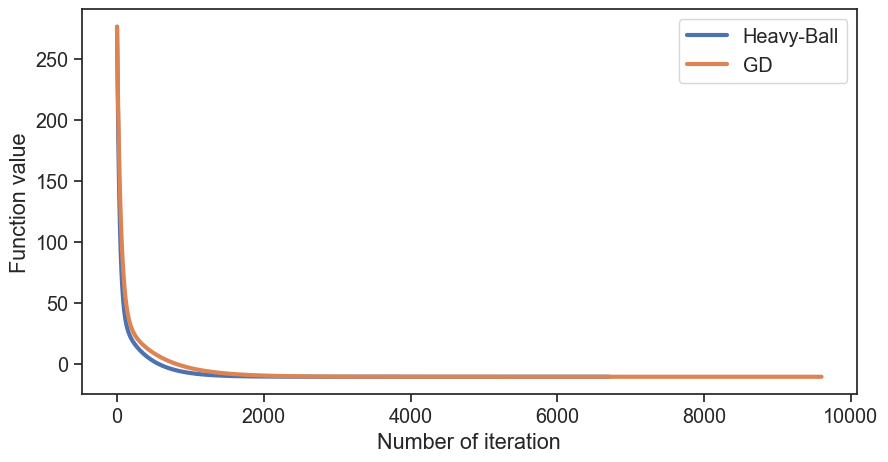

In [41]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

Те же графики в лог-лог шкале

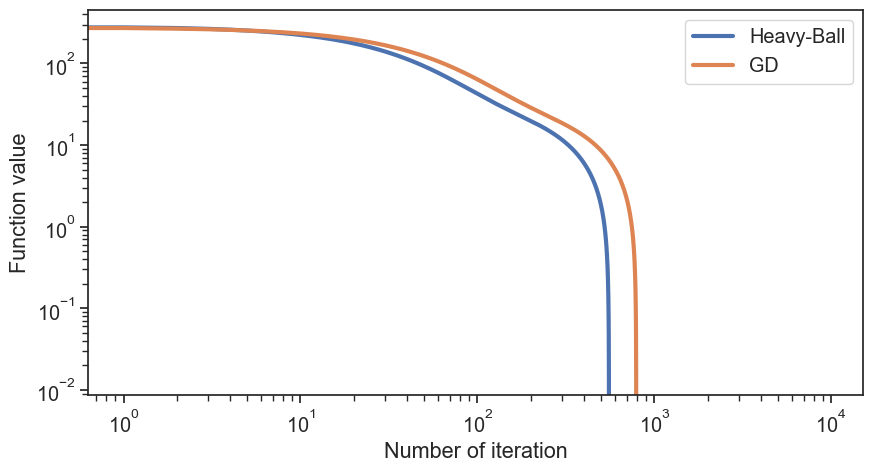

In [42]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Оба метода сходятся примерно за одинаковое количество итераций, при этом Heavy-Ball может вести себя немонотонно

### Nesterov momentum


$$ x_{k+1} = x_k + \beta_k (x_k - x_{k-1}) - \alpha_k \nabla f (x_k + \beta_k (x_k - x_{k-1})) $$

$$ \alpha_k, ~ \beta_k - \text{параметры} $$

In [43]:
def Nesterov_momentum(x0: np.ndarray, A: np.ndarray, b: np.ndarray,
                      N: int, eps: float, y0: Optional[np.ndarray] = None, verbose: bool = False):
    """
    Nesterov method for quadratic functions
    
    :param x0: initial guess of x
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param N: max number of iterations
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    eigen_vals = np.linalg.eigvals(A)
    mu = np.min(eigen_vals)  # константа сильной выпуклости
    L = np.max(eigen_vals)  # константа Липшица
    
    n = len(x0)
    x = np.zeros((N, n))
    y = np.zeros((N, n))
    x[0] = x0
    if y0 is None: y[0] = x0

    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], A, b)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    end_iteration = N

    for k in range(N-1):
        # compute params
        alpha_k = 1 / L
        beta_k = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
        # beta_k = k / (k + 3)
        
        # method step
        x[k+1] = y[k] - alpha_k * grad_f(y[k], A, b)
        y[k+1] = x[k+1] + beta_k * (x[k+1] - x[k])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'Nesterov converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) Nesterov didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [52]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [53]:
N = int(1e4)
eps = 1e-8

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([9.70925976, 7.65428676])

Сравнение

In [54]:
f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)

INFO: Nesterov converge at 26 iteration, min f(x) = -5.8505667379044075


In [55]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, A, b, x0)

INFO: GD converge at 7414 iteration, min f(x) = -5.8505547642372076


In [56]:
scipy.optimize.minimize(f, x0, args=(A, b))

      fun: -5.850585762654249
 hess_inv: array([[ 1.01445276, -0.00274721],
       [-0.00274721,  0.1005222 ]])
      jac: array([ 1.84774399e-06, -3.33786011e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-3.40231949, -0.1119741 ])

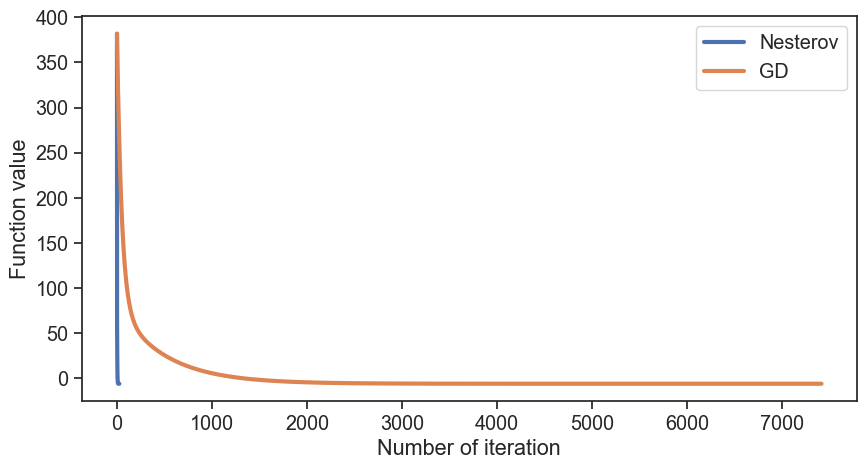

In [57]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

В лог-лог шкале

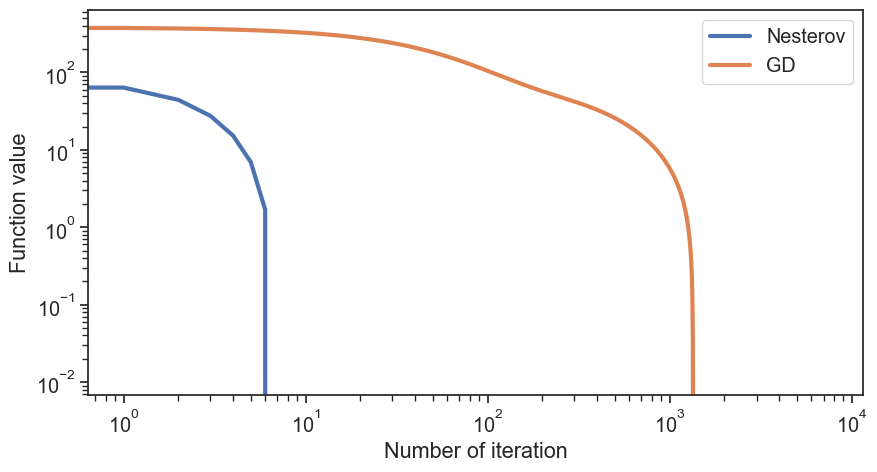

In [58]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Метод Нестерова сходится в среднем в 2-10 раз быстрее чем градиентный спуск

### Генерация 9 матриц с разными числами обусловленности

In [59]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -3.6977352883969514
INFO: HB converge at 8050 iteration, min f(x) = -3.6977352842905242


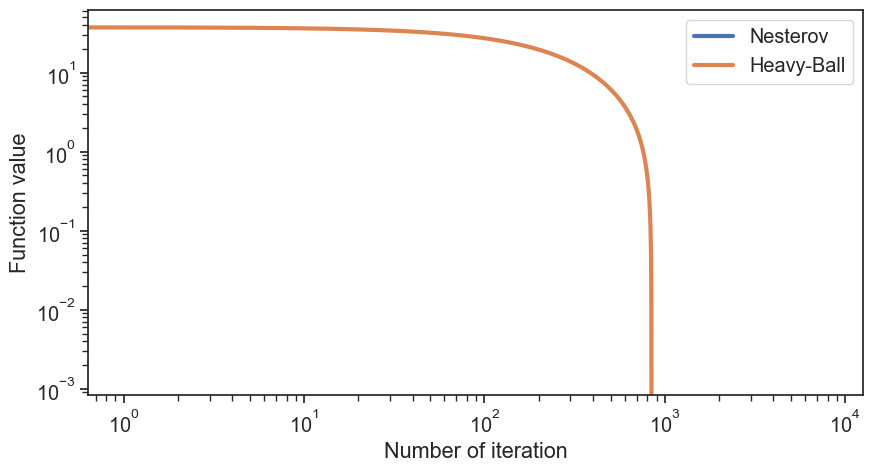

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 90 iteration, min f(x) = -10.268838160264156
INFO: HB converge at 5006 iteration, min f(x) = -10.268837479037273


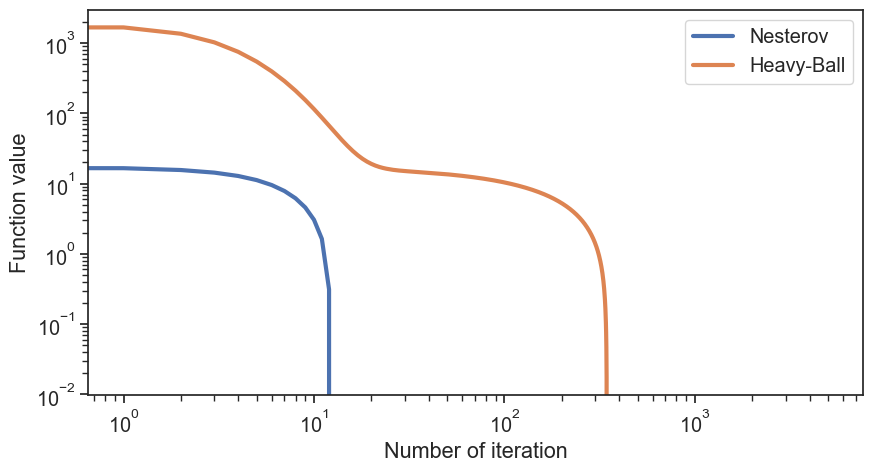

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 214 iteration, min f(x) = -8.962886888494445
INFO: HB converge at 3368 iteration, min f(x) = -8.962851216186719


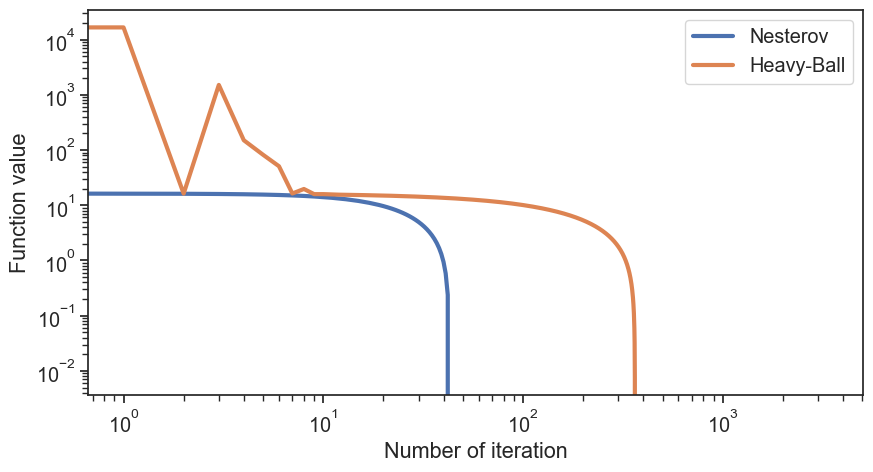

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -35.00306791396116
INFO: HB converge at 7439 iteration, min f(x) = -35.00306788496387


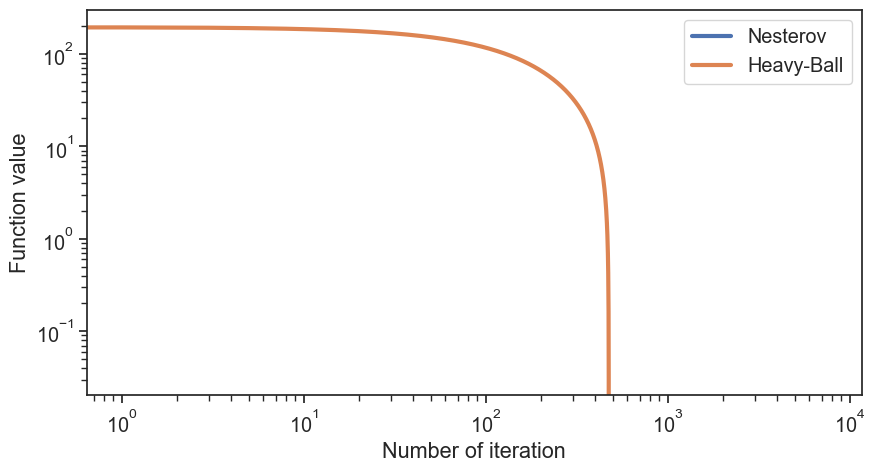

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 88 iteration, min f(x) = -9.669551086993415
INFO: HB converge at 4849 iteration, min f(x) = -9.669547228847572


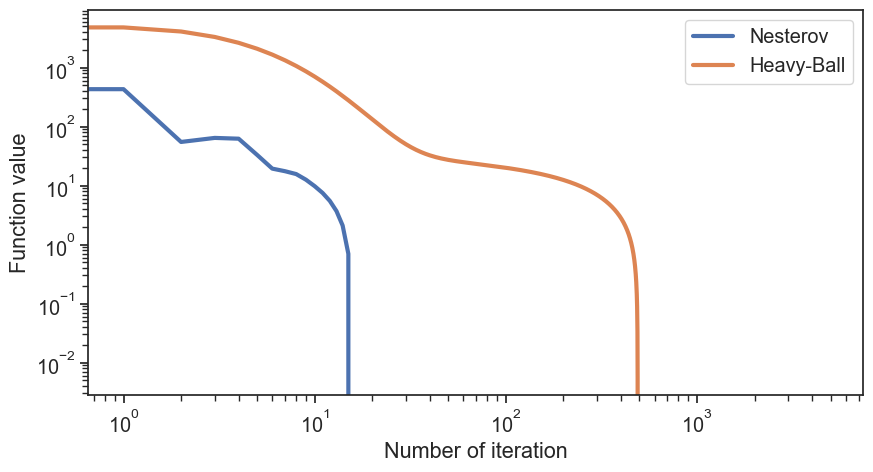

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 197 iteration, min f(x) = -6.158756364763741
INFO: HB converge at 3028 iteration, min f(x) = -6.1586497975398595


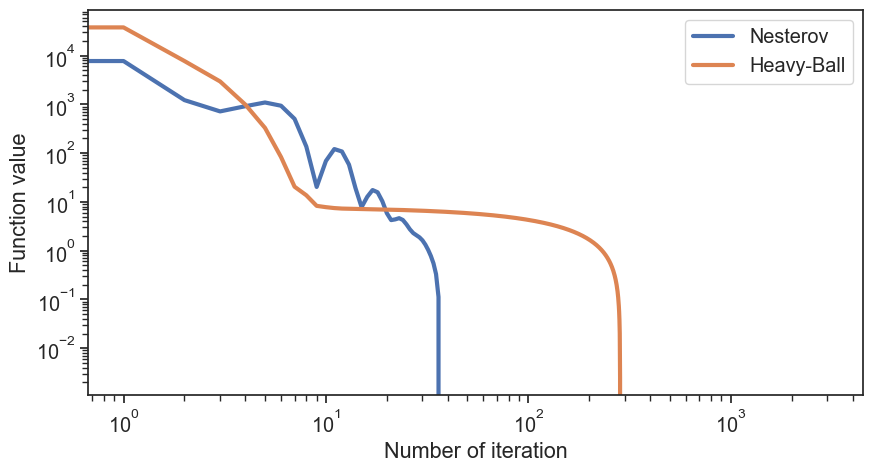

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -2776.5452420728234
INFO: HB converge at 6856 iteration, min f(x) = -2776.5452393872356


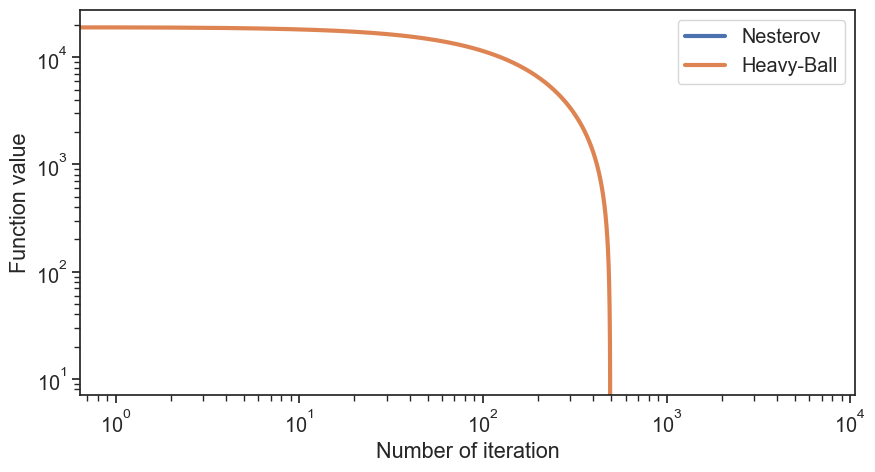

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 70 iteration, min f(x) = -192.1710986631195
INFO: HB converge at 3710 iteration, min f(x) = -192.17061545115862


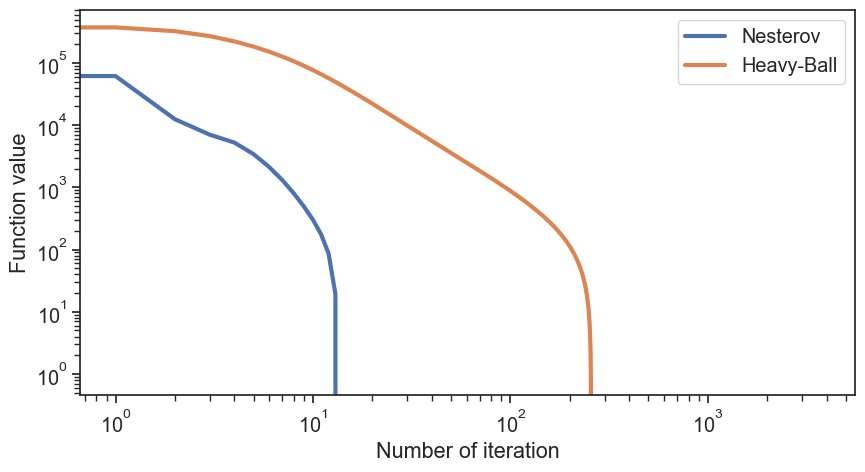

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 148 iteration, min f(x) = -30.59537864140676
INFO: HB converge at 1592 iteration, min f(x) = -30.425384136739993


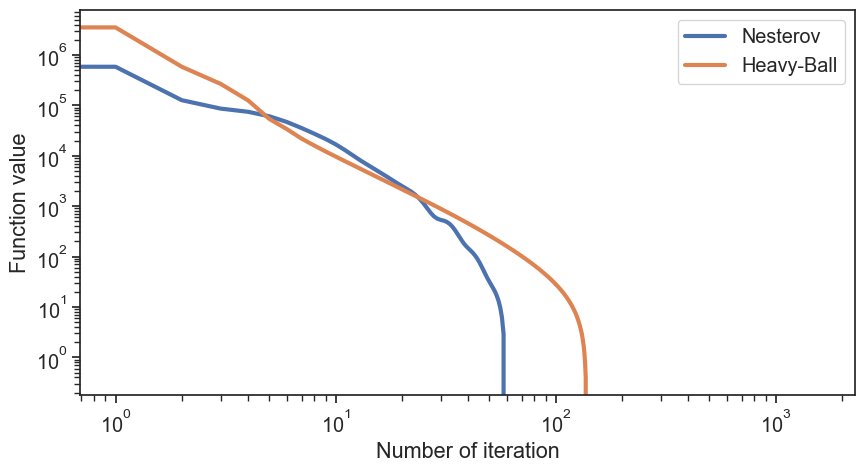

In [60]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
            
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -3.6977352883969514
INFO: HB converge at 8050 iteration, min f(x) = -3.697734689650444


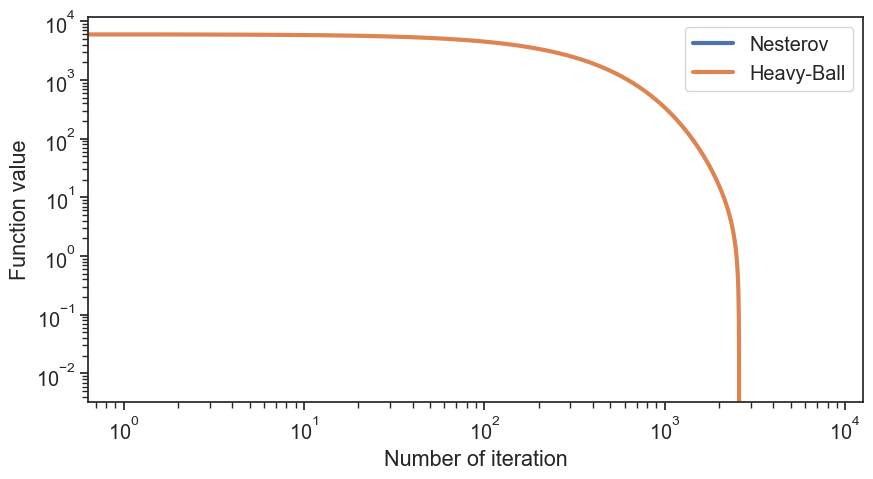

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 96 iteration, min f(x) = -10.267925557899071
INFO: HB converge at 5357 iteration, min f(x) = -10.267736269828964


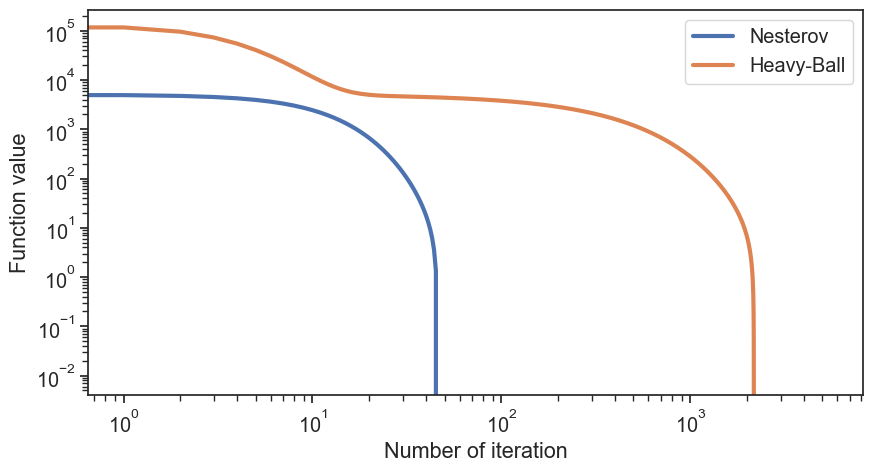

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 233 iteration, min f(x) = -8.854341724884597
INFO: HB converge at 3746 iteration, min f(x) = -8.852968052877387


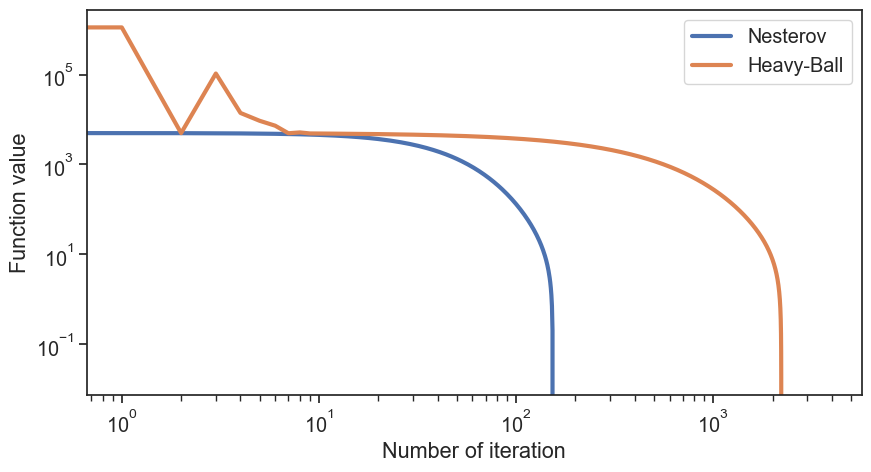

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 9 iteration, min f(x) = -35.00306393716491
INFO: HB converge at 7076 iteration, min f(x) = -35.00306053519506


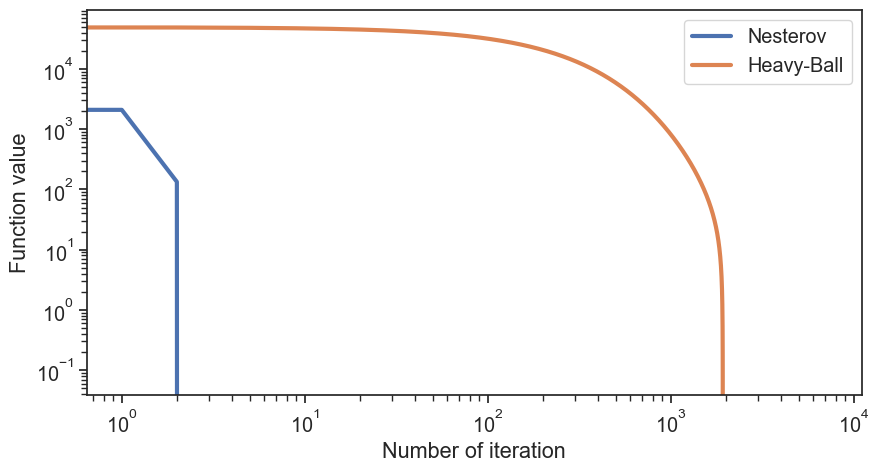

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 77 iteration, min f(x) = -9.650995911746667
INFO: HB converge at 4139 iteration, min f(x) = -9.649816356229215


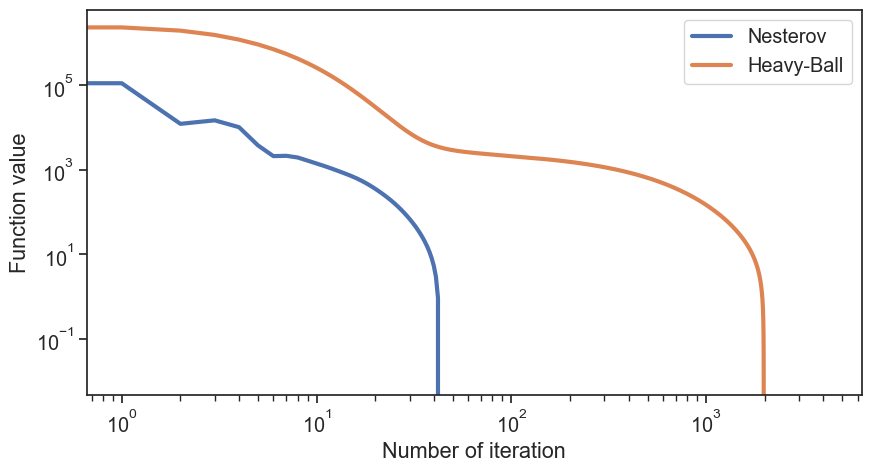

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 195 iteration, min f(x) = -5.32289887198935
INFO: HB converge at 2993 iteration, min f(x) = -5.2934201746372995


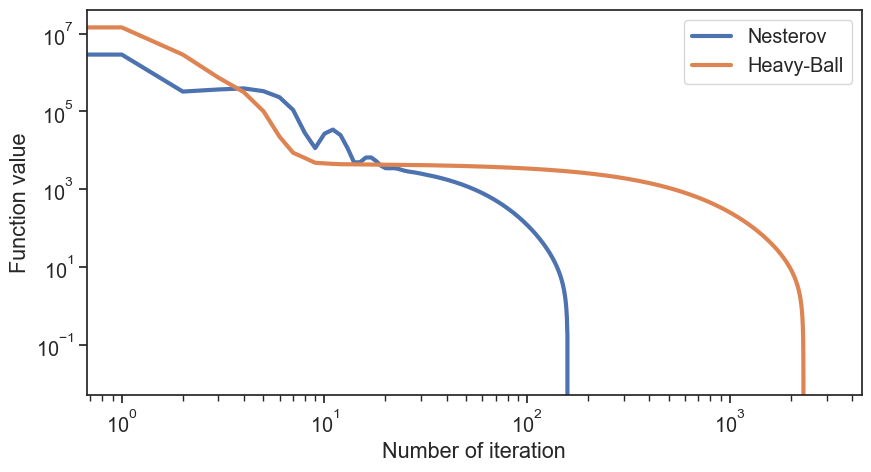

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 9 iteration, min f(x) = -2776.544737169692
INFO: HB converge at 6729 iteration, min f(x) = -2776.5447290995653


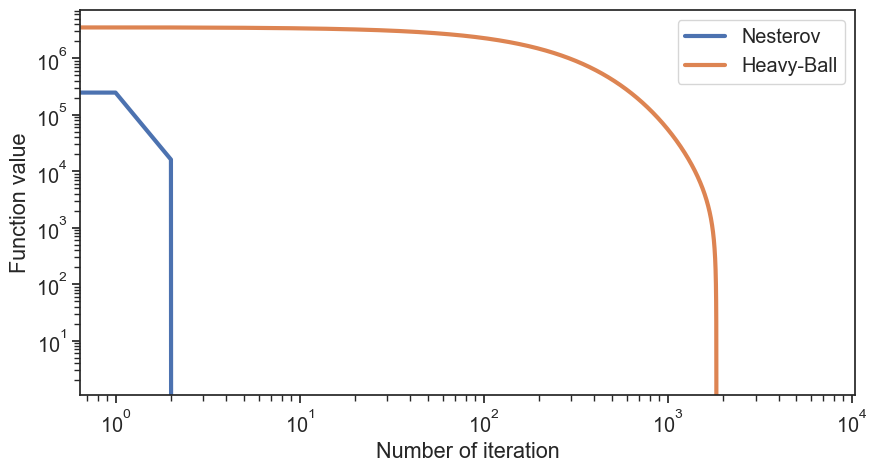

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 62 iteration, min f(x) = -191.75683877284874
INFO: HB converge at 3070 iteration, min f(x) = -191.4418757042746


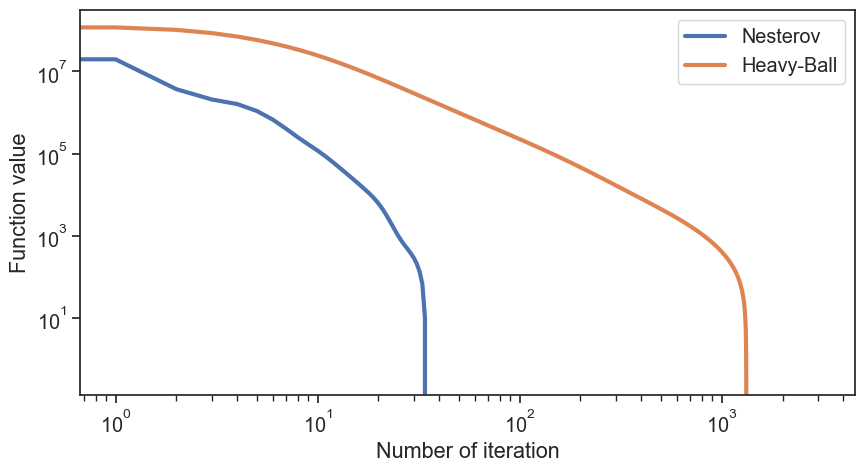

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 148 iteration, min f(x) = -26.411082902630135
INFO: HB converge at 435 iteration, min f(x) = 10.616339972804195


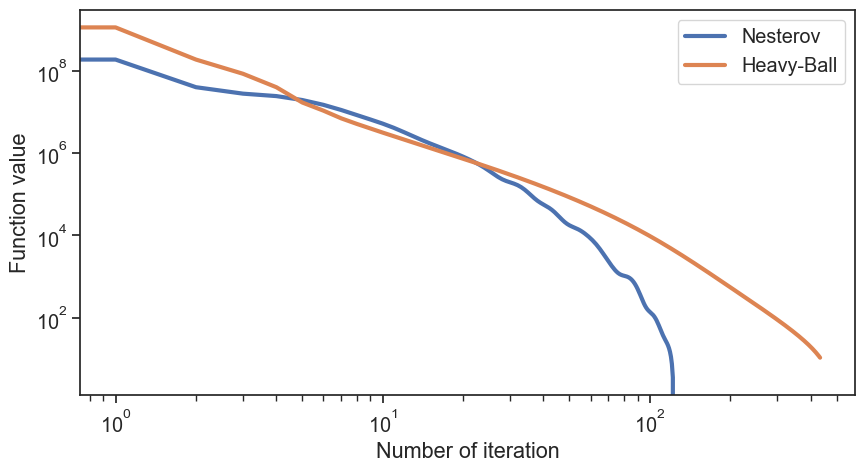

In [61]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=32)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -3.6977352883969514
INFO: HB converge at 4026 iteration, min f(x) = -3.6973248486853256


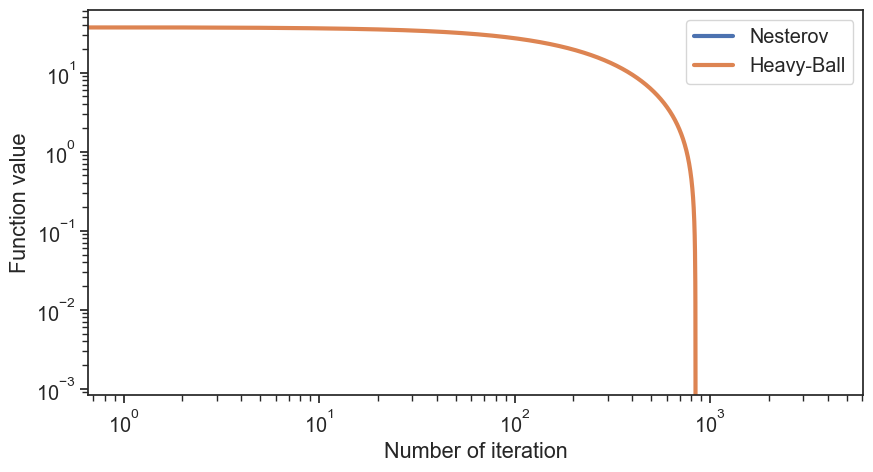

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 26 iteration, min f(x) = -8.785945737210008
INFO: HB converge at 982 iteration, min f(x) = -8.610989949092923


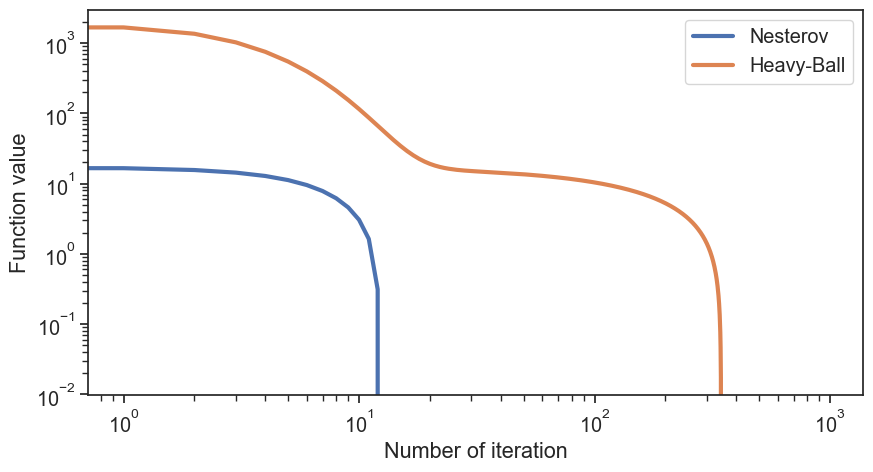

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 1 iteration, min f(x) = 16.22819834921666
INFO: HB converge at 2 iteration, min f(x) = 16.22819834921666


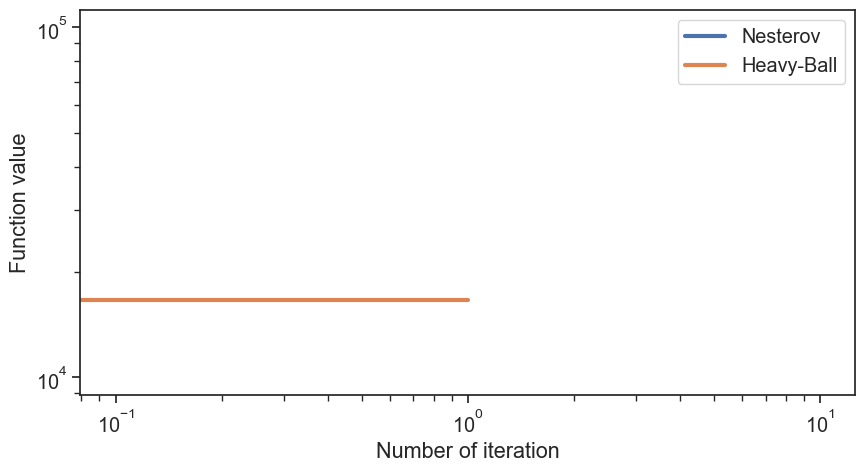

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 5 iteration, min f(x) = -35.00173169272617
INFO: HB converge at 3464 iteration, min f(x) = -34.99978884494419


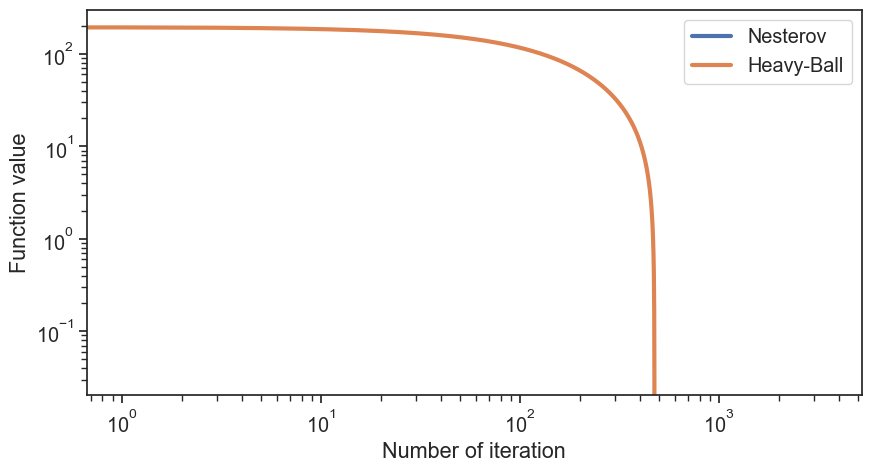

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 23 iteration, min f(x) = -6.329708228615512
INFO: HB converge at 825 iteration, min f(x) = -5.969755511564129


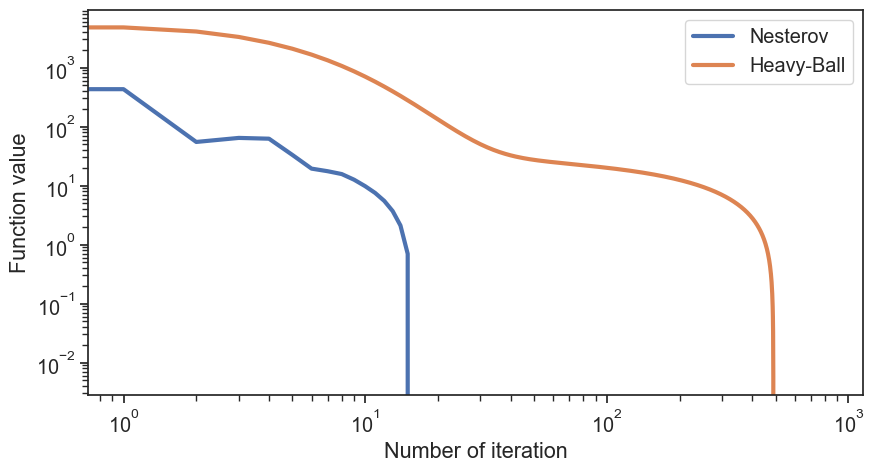

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 21 iteration, min f(x) = 4.2322587205960005
INFO: HB converge at 11 iteration, min f(x) = 7.466556122619785


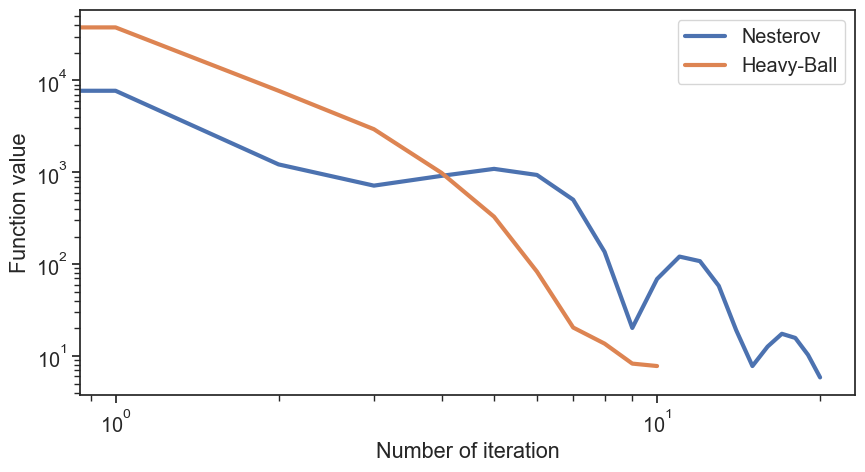

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 5 iteration, min f(x) = -2776.449923377426
INFO: HB converge at 3130 iteration, min f(x) = -2776.248148337717


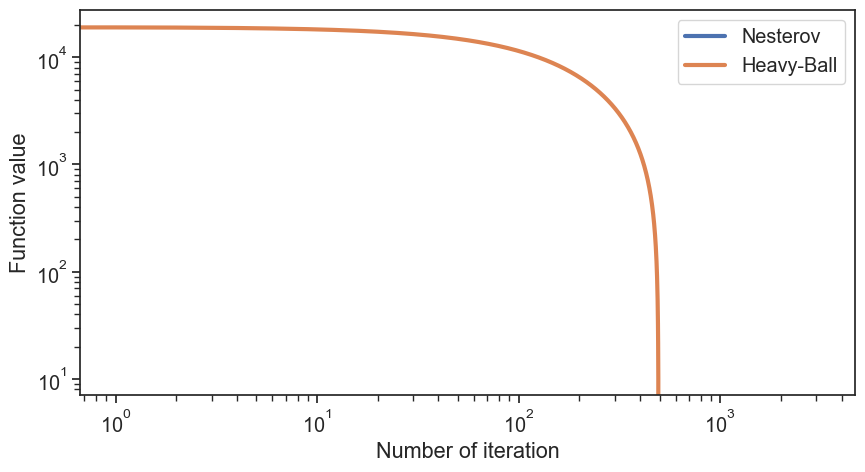

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 19 iteration, min f(x) = -142.0063352096701
INFO: HB converge at 324 iteration, min f(x) = -68.03043709081247


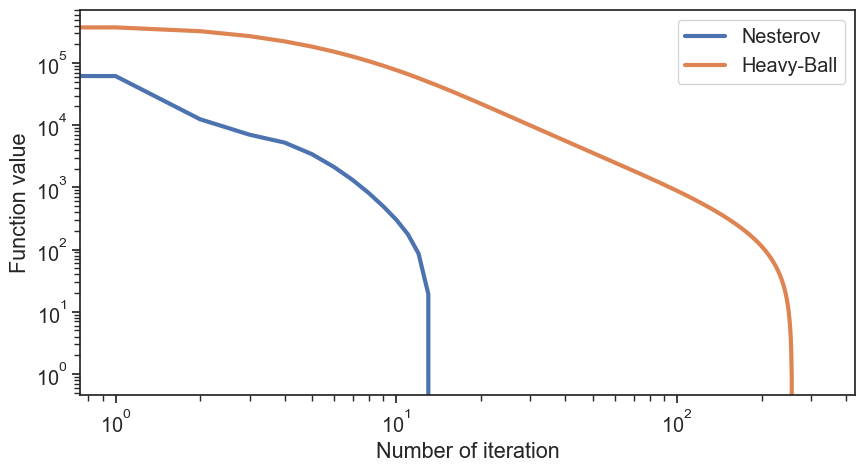

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 35 iteration, min f(x) = 327.06720593493515
INFO: HB converge at 30 iteration, min f(x) = 889.7125151641637


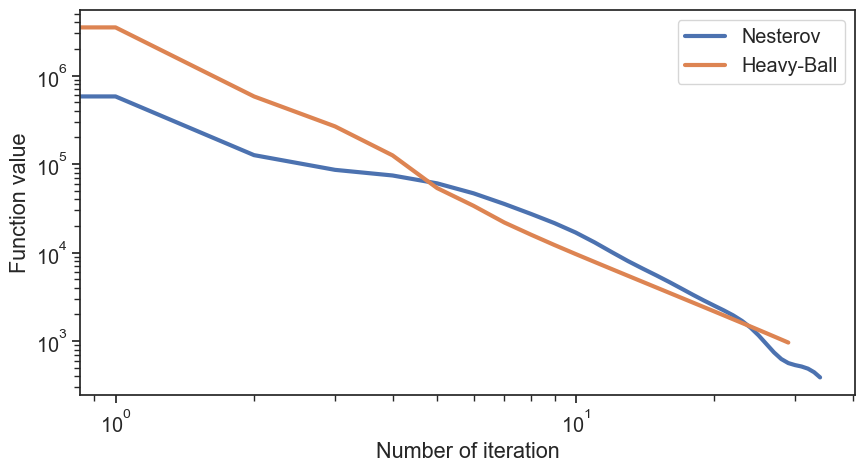

In [62]:
N = int(1e4)
eps = 1e-5

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -3.6977352883969514
INFO: HB converge at 6441 iteration, min f(x) = -3.697734878539562


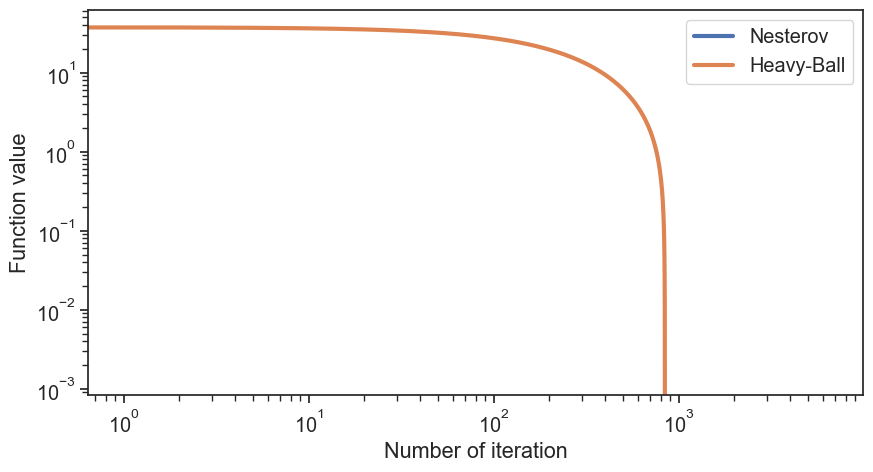

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 66 iteration, min f(x) = -10.267410165461383
INFO: HB converge at 3397 iteration, min f(x) = -10.267198553905596


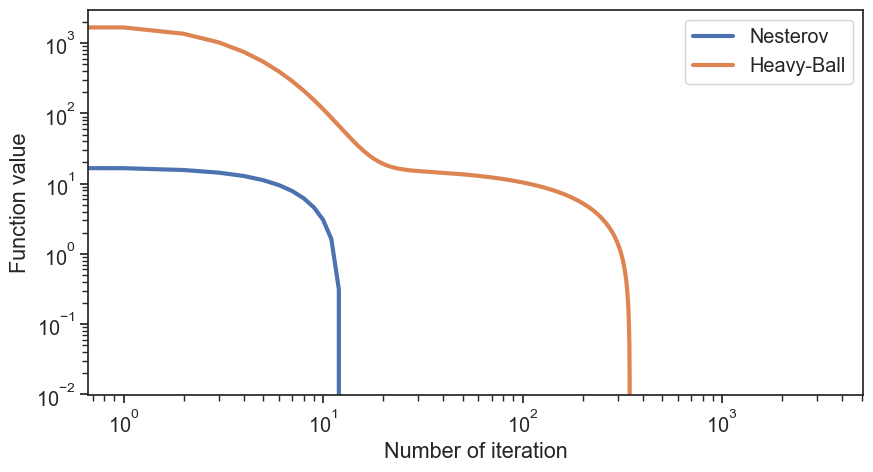

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 129 iteration, min f(x) = -8.80110623961854
INFO: HB converge at 1759 iteration, min f(x) = -8.799167689002791


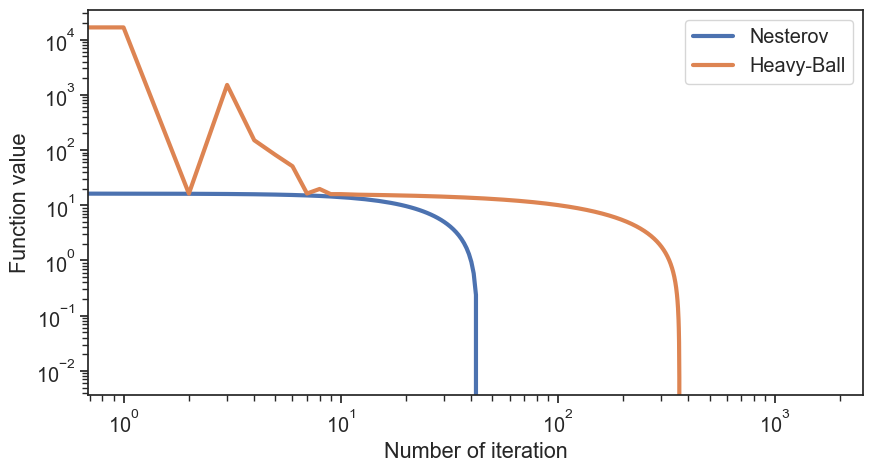

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 8 iteration, min f(x) = -35.00306722092119
INFO: HB converge at 5843 iteration, min f(x) = -35.00306460494788


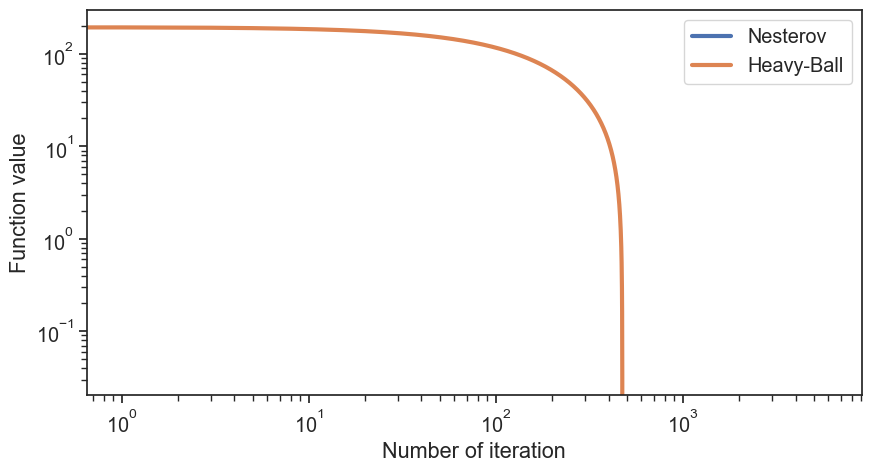

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 63 iteration, min f(x) = -9.66601429316255
INFO: HB converge at 3239 iteration, min f(x) = -9.665879080830377


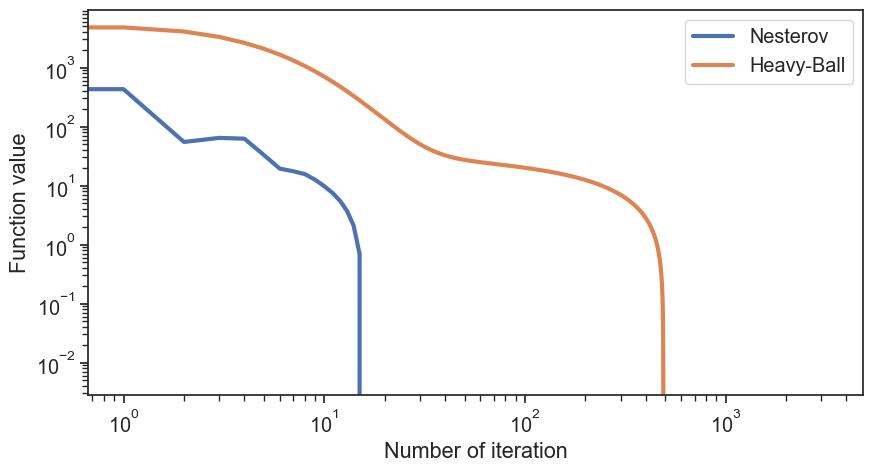

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 110 iteration, min f(x) = -5.925006463304226
INFO: HB converge at 1418 iteration, min f(x) = -5.920699359373975


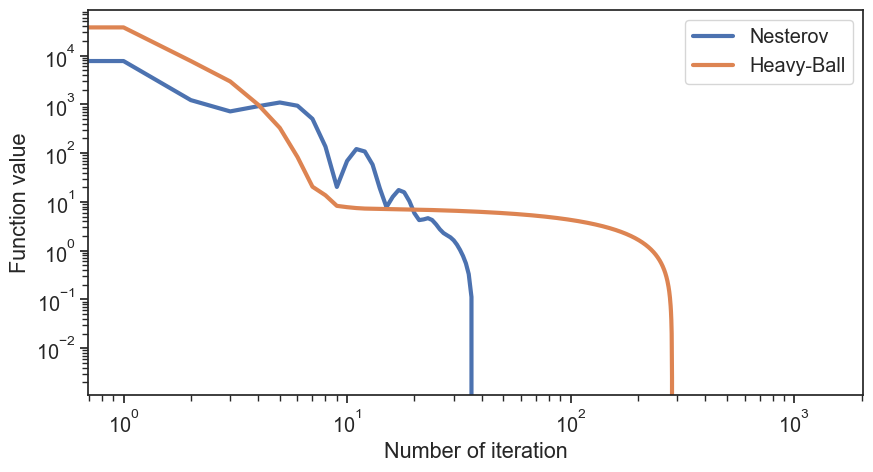

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 8 iteration, min f(x) = -2776.5451816451487
INFO: HB converge at 5342 iteration, min f(x) = -2776.544933621338


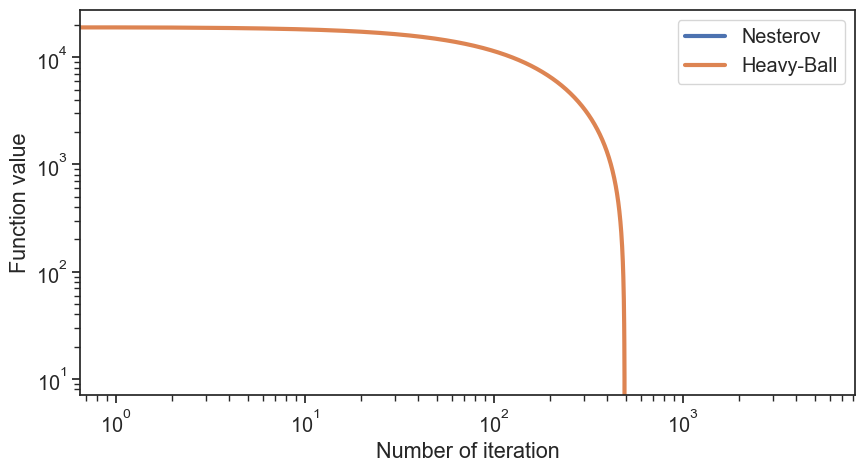

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 47 iteration, min f(x) = -191.99382217888336
INFO: HB converge at 2172 iteration, min f(x) = -191.93354273258984


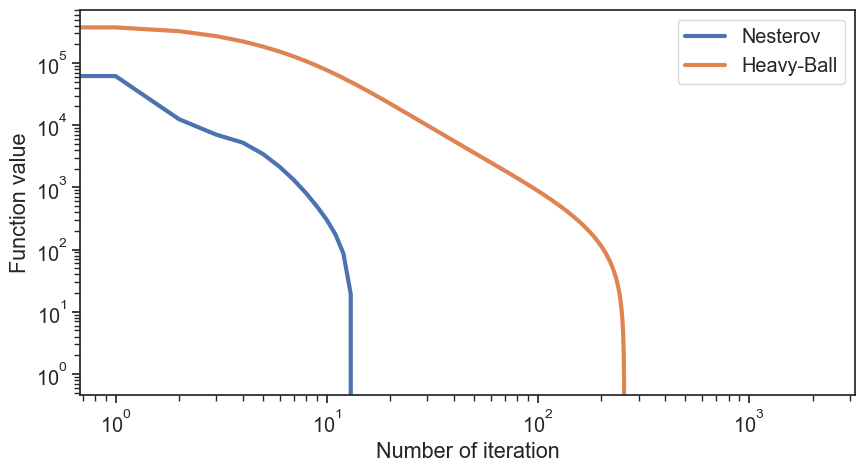

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 95 iteration, min f(x) = -28.8600311772868
INFO: HB converge at 240 iteration, min f(x) = -17.45088939026575


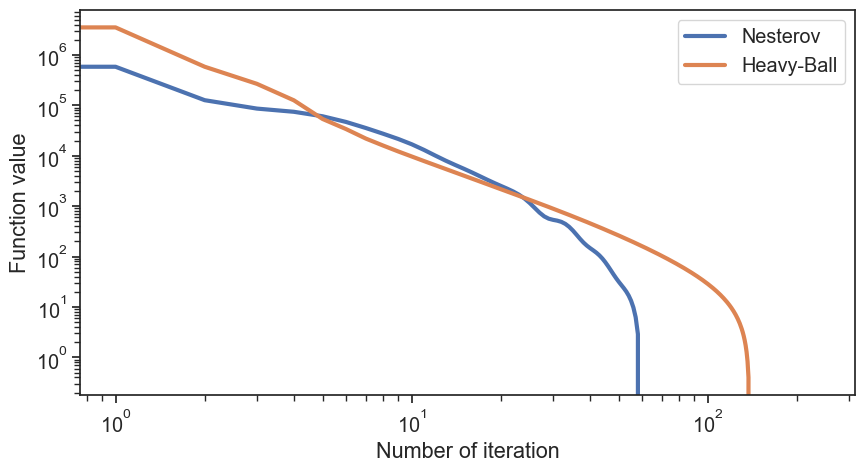

In [63]:
N = int(1e4)
eps = 1e-8

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -3.6977352883969514
INFO: HB converge at 9660 iteration, min f(x) = -3.6977352883559256


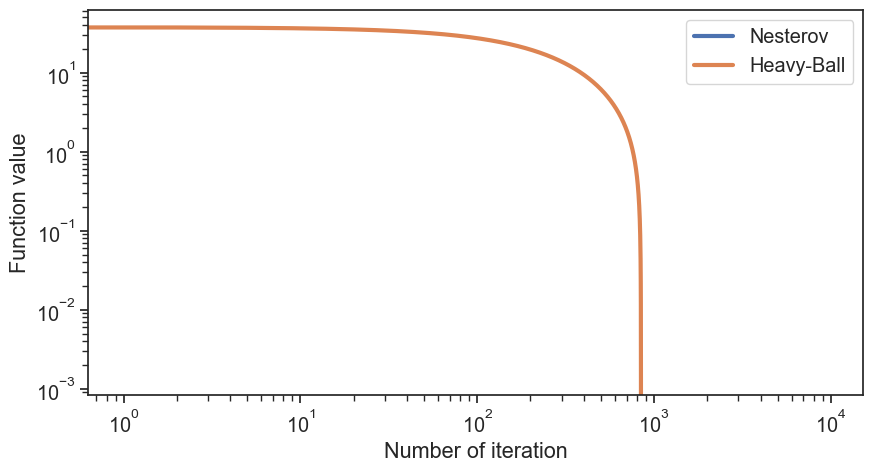

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 114 iteration, min f(x) = -10.268853910271941
INFO: HB converge at 6616 iteration, min f(x) = -10.268853900169294


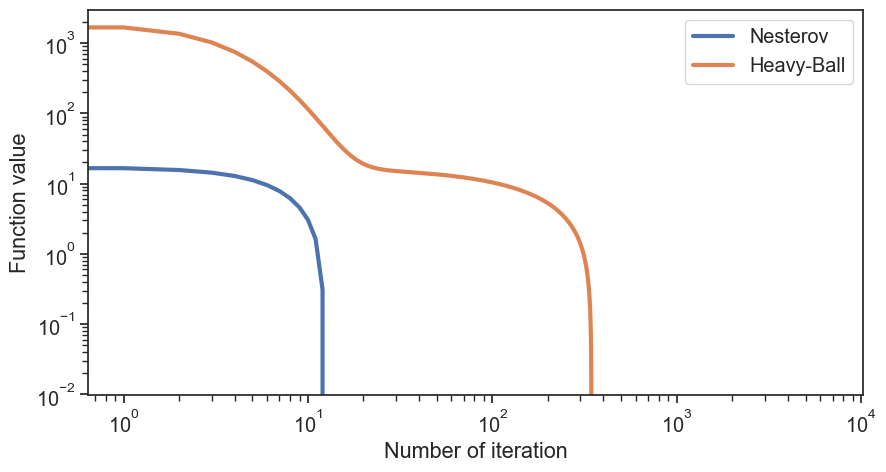

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 295 iteration, min f(x) = -8.964492062651868
INFO: HB converge at 4978 iteration, min f(x) = -8.964491235463758


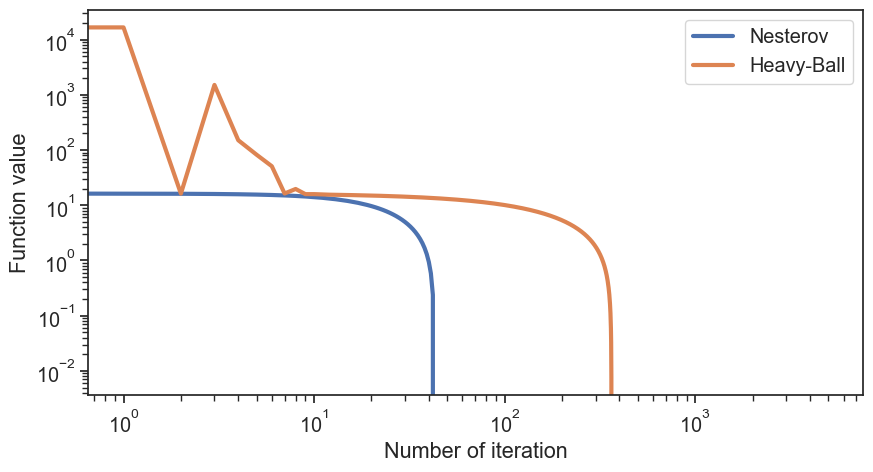

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 11 iteration, min f(x) = -35.00306791781759
INFO: HB converge at 9038 iteration, min f(x) = -35.00306791780092


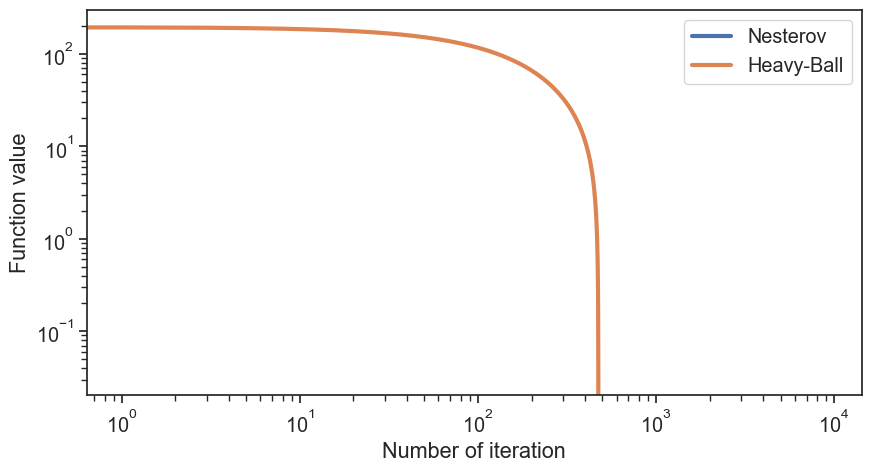

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 112 iteration, min f(x) = -9.669583918474338
INFO: HB converge at 6459 iteration, min f(x) = -9.669583875624275


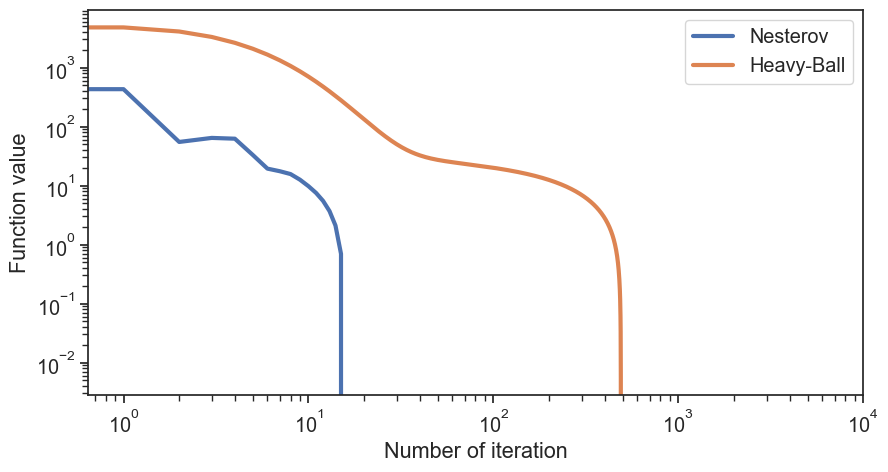

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 278 iteration, min f(x) = -6.161027953423335
INFO: HB converge at 4637 iteration, min f(x) = -6.161026981998138


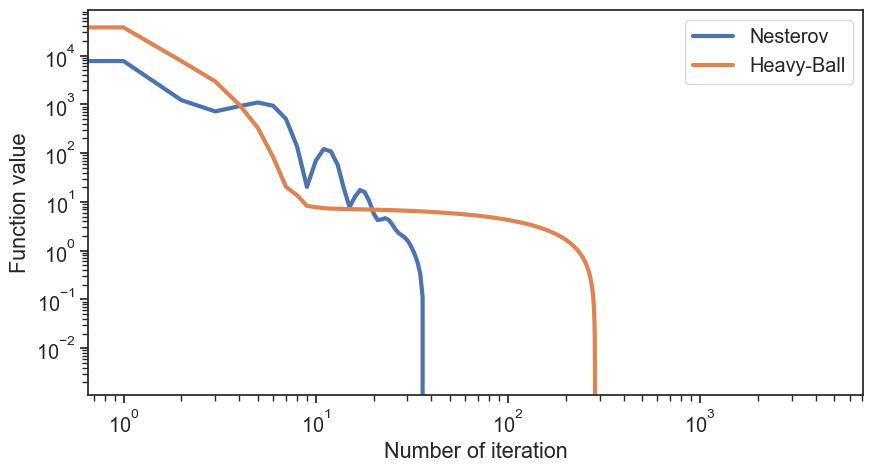

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 12 iteration, min f(x) = -2776.5452425221274
INFO: HB converge at 8389 iteration, min f(x) = -2776.545242493786


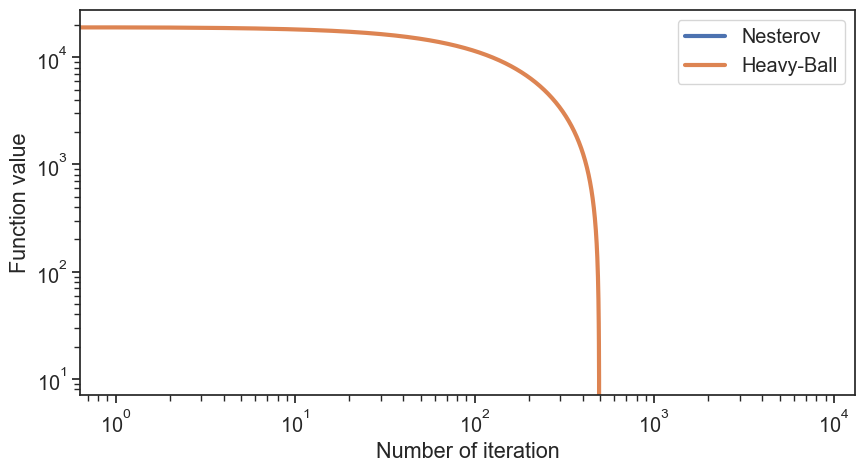

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 92 iteration, min f(x) = -192.1730362862442
INFO: HB converge at 5269 iteration, min f(x) = -192.17303471804402


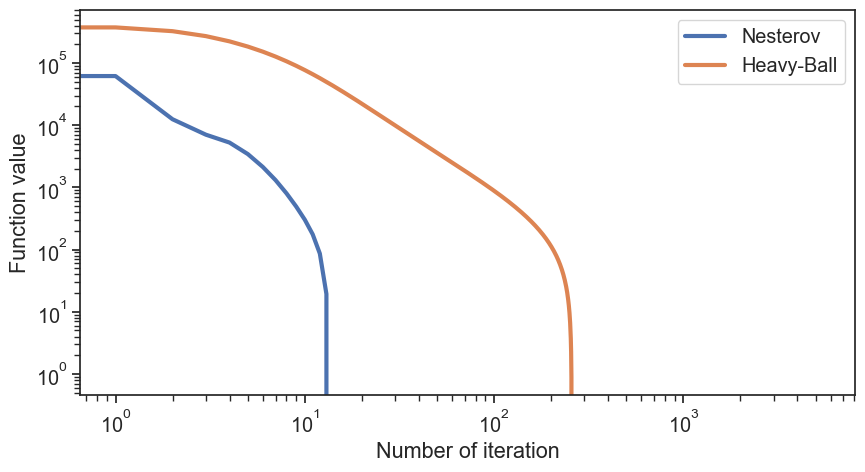

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 213 iteration, min f(x) = -30.659567775955736
INFO: HB converge at 3201 iteration, min f(x) = -30.6587710078372


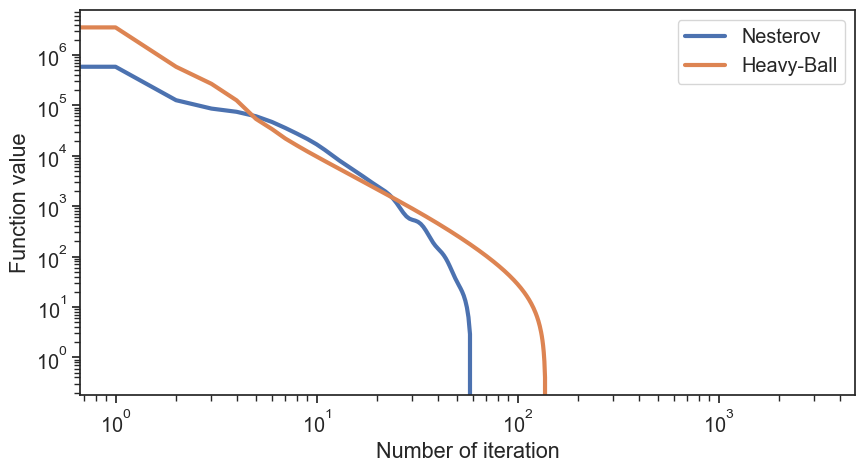

In [64]:
N = int(1e4)
eps = 1e-12

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Для плохообусловленных задач следует повышать требуемую точность.

При `n = 1000, cond_num = 1000` результаты работы метода Нестерова и метода тяжелого шарика совпадают только при высокой точности `eps = 1e-12`

### Разные начальные условия

In [65]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

$$ x_0 = y_0 = 0_n $$

In [66]:
x0 = np.zeros(n)
y0 = np.zeros(n)

In [67]:
eps = 1e-8

f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps, y0=y0)

INFO: Nesterov converge at 28 iteration, min f(x) = -15.94798855077358


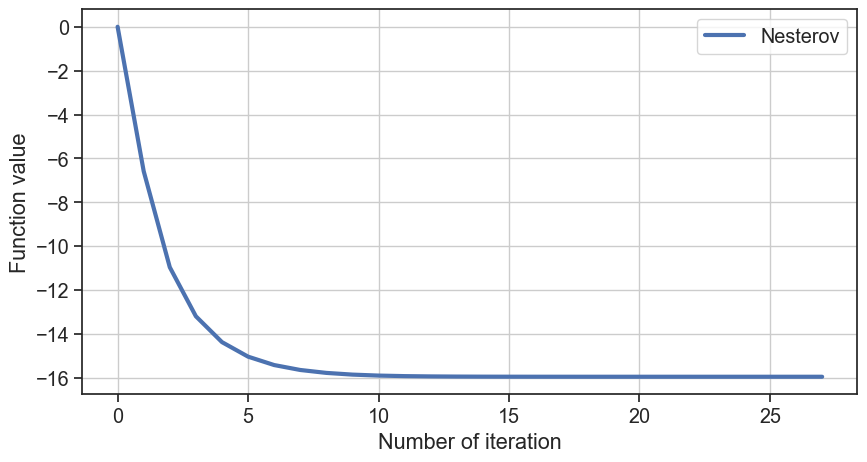

In [68]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

$$ x_0 = 0_n, ~ y_0 = 1_n $$

In [69]:
x0 = np.zeros(n)
y0 = np.ones(n)

In [70]:
eps = 1e-8

f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps, y0=y0)

INFO: Nesterov converge at 28 iteration, min f(x) = -15.94798855077358


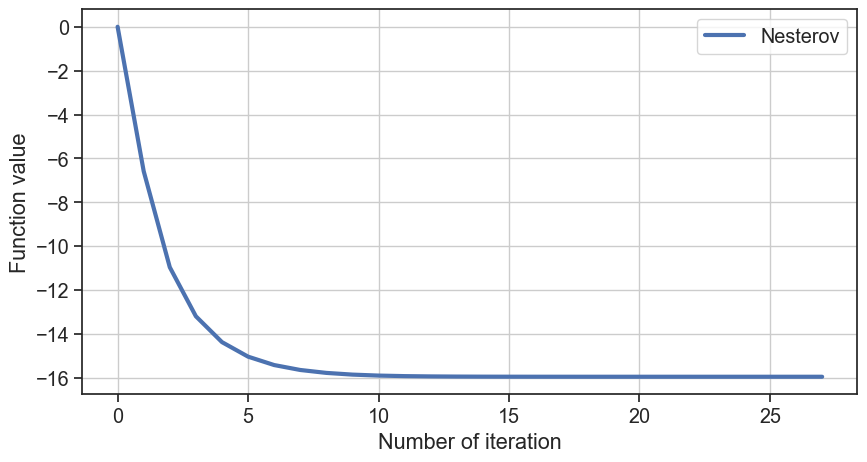

In [71]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

Метод Нестерова работает одинаково для двух данных начальных условий

# End